In [1]:
import pyart 
import numpy as np
import pandas as pd
import warnings
import xarray
from siphon.simplewebservice.iastate import IAStateUpperAir
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=RuntimeWarning)
from datetime import datetime
import glob, os
import auto_filter,snr_noise,attenuation,calc_kdp,tools,retrieval,echo_classification
import gridrad_homeyer
from skimage import measure


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [41]:
# Setting relevant paths
#-------------------------------------------------------------------------------------------------
input_gridpath = '/scra6/ft21894/radartrunk/0713/'
radargridlist = sorted(glob.glob(input_gridpath+'KDLH_KMPX*.nc')) #KABR_KFSD
input_gridrad = sorted(glob.glob('/scra6/ft21894/radartrunk/NEXRAD_mosaic/0620_plot/'+'*.nc'))
#Bowman, K. P., and C. R. Homeyer. 2017. (cite:https://rda.ucar.edu/datasets/ds841.0/)

# Read in grid files and save data time
#-------------------------------------------------------------------------------------------------
base = pyart.io.read_grid(radargridlist[-1]) #0620b:10 0701:4 0706:0,8 0617:11;7,19 (LNX),
base.fields.keys()
dt = datetime.strptime(base.time['units'][-20:], '%Y-%m-%dT%H:%M:%SZ')

In [3]:
len(radargridlist)

1

In [3]:
gridrad2 = []
for i in range(len(input_gridrad)):
    gridrad2.append(gridrad_homeyer.read_file(input_gridrad[i]))
#gridrad2 = []
#for i in range(len(input_gridrad)):
#    gridrad2.append(gridrad_homeyer.remove_clutter(gridrad[i]))

In [4]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    import matplotlib
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

In [5]:
import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib
import pyart.graph.cm as pyartcm
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.feature as feature
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.mpl.ticker as cticker
from scipy.ndimage.filters import gaussian_filter
import seaborn as sns
import matplotlib.font_manager as fm
import cartopy.crs as crs
import cartopy_set
from shapely import geometry
GeoAxes._pcolormesh_patched = Axes.pcolormesh

def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

cimgt.Stamen.get_image = image_spoof # reformat web request for street map spoofing
osm_img = cimgt.Stamen('terrain') # spoofed, downloaded street map

def add_sub_region_box(ax, subregion,facecolor='none',edgecolor='r',linewidth=2.3):
    """ """
    geom = geometry.box(minx=subregion[0],maxx=subregion[1],miny=subregion[2],maxy=subregion[3])
    ax.add_geometries([geom], crs=crs.PlateCarree(), facecolor=facecolor,edgecolor=edgecolor,linewidth=linewidth)
    return ax

In [15]:
def display_mosaic(gridrad=None,EXTENT=None,loopstep=[1,2],laststep=3,
                   lambert_proj=crs.LambertConformal(central_longitude=-92.0, central_latitude=33.0),
                  cmap_brightdark=[0.5,0.8,0.8],alpha=[0.5,0.7,0.85],plot_domain=[450,950+200,850-100,1350],
                   plot_dlast=[550,950+200,850-100,1350],nexrad_lon=None,nexrad_lat=None,
                   mobile_lon=None,mobile_lat=None,xticks=None,yticks=None,date='2015/06/20'
                  ):
    from matplotlib.lines import Line2D
    sns.set_style('white')
    sns.set_context('poster',font_scale=0.66)
    prop = fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf')
    plt.rcParams["axes.axisbelow"] = True
    
    osm_img = cimgt.Stamen('terrain')
    fig = plt.figure(figsize=(11.5-1.75,10.5-1.75))
    ax = fig.add_subplot(1, 1, 1,projection=lambert_proj)
    states_provinces = feature.NaturalEarthFeature(category='cultural',
                                                   name='admin_1_states_provinces_lines',scale='10m',facecolor='none')
    ax.add_feature(feature.NaturalEarthFeature(category='physical',name='lakes',scale='50m',facecolor='none'))
    coastline = feature.NaturalEarthFeature(category='physical',name='coastline',scale='10m',facecolor='none')
    ax.set_extent(EXTENT,crs.PlateCarree())
    ax.add_feature(states_provinces, linewidth=1.5,edgecolor='k')
    ax.add_feature(feature.BORDERS,linewidth=1.75, edgecolor='k')
    ax.add_feature(coastline, linewidth=1.5, edgecolor='k')
    
    request = cimgt.OSM()
    ax.add_image(request, 8)
    #scale = np.ceil(-np.sqrt(2)*np.log(np.divide((EXTENT[1]-EXTENT[0])/2.0,350.0))) # empirical solve for scale based on zoom
    #scale = (scale<20) and scale or 19 # scale cannot be larger than 19
    #ax.add_image(osm_img, int(scale))
    
    cmap_set = [0.5,0.8,0.8]
    alpha = [0.5,0.7,0.85]
    for i in loopstep:
        wspd_contours = plt.pcolormesh(gridrad2[i]['x']['values'][plot_domain[0]:plot_domain[1]],
                                       gridrad2[i]['y']['values'][plot_domain[2]:plot_domain[3]],
                                       np.ma.masked_less(np.nanmax(
                                           gridrad2[i]['Z_H']['values'],axis=0),30)[plot_domain[2]:plot_domain[3],plot_domain[0]:plot_domain[1]],
                                       cmap =cmap_map(lambda x: x*cmap_set[i], pyart.graph.cm.LangRainbow12),
                                       vmin=20,vmax=60,shading='auto',antialiased=True,transform=crs.PlateCarree(),
                                       alpha=alpha[i])
    wspd_contours3 = plt.pcolormesh(gridrad2[laststep]['x']['values'][plot_dlast[0]:plot_dlast[1]],
                                    gridrad2[laststep]['y']['values'][plot_dlast[2]:plot_dlast[3]],
                                    np.ma.masked_less(np.nanmax(
                                        gridrad2[laststep]['Z_H']['values'],axis=0),33)[plot_dlast[2]:plot_dlast[3],plot_dlast[0]:plot_dlast[1]],
                                    cmap =cmap_map(lambda x: x, pyart.graph.cm.LangRainbow12),
                                    vmin=20,vmax=60,shading='auto',alpha=0.9,antialiased=True,
                                    transform=crs.PlateCarree())
    #add_sub_region_box(ax, [-99.75,-97.45,44,45.46],facecolor='none',edgecolor='r',linewidth=1.3)
    #CBAR
    #---------------------------------------------------------------------------------------------------------------
    CBAR = plt.colorbar(wspd_contours3,shrink=0.627,ticks=[0,10,20,30,40,50,60])
    CBAR.ax.tick_params(direction='out',length=6,width=3,colors='k')
    CBAR.ax.set_yticklabels([0,10,20,30,40,50,60],fontproperties=prop,fontsize=12.5)
    for txt in CBAR.ax.get_yticklabels():
        txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=13))
    CBAR.outline.set_linewidth(2.5)
    CBAR.set_label('Reflectivity (dBZ)',fontproperties=prop,fontsize=13.5)
    
    #Radar location
    #--------------------------------------------------------------------------------------------------
    for i in range(len(nexrad_lon)):
        plt.plot(nexrad_lon[i], nexrad_lat[i], marker='s', color='yellow', 
                 markersize=7.5,mec='k',transform=crs.Geodetic(),lw=0)
    if mobile_lon is None:
        legend_elements = [Line2D([0], [0], marker='s', color='yellow', label='NEXRAD Radars',
                          markerfacecolor='yellow', markersize=7.5,mec='k',lw=0)]
        ax.legend(handles=legend_elements,fontsize='x-small',\
                 prop=dict(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf',size=9.25), \
                 frameon=True, fancybox=True, shadow=True, loc=3)
        fig.canvas.draw()
    else:
        for i in range(len(mobile_lon)):
            plt.plot(mobile_lon[i],mobile_lat[i],marker='s', color='r',
                     markersize=5.5,mec='k',transform=crs.Geodetic(),lw=0)
        legend_elements = [Line2D([0], [0], marker='s', color='yellow', label='NEXRAD Radars',
                          markerfacecolor='yellow', markersize=7.5,mec='k',lw=0),
                           Line2D([0], [0], marker='s', color='r', label='Mobile Radars',
                          markerfacecolor='r', markersize=7.5,mec='k',lw=0)]
        ax.legend(handles=legend_elements,fontsize='x-small',\
                 prop=dict(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf',size=9.25), \
                 frameon=True, fancybox=True, shadow=True, loc=3)
        fig.canvas.draw()
    
    # Gridlines, Tickmarks, and labeling
    ax.gridlines(xlocs=xticks, ylocs=yticks,linewidth=0.5, color='k', alpha=0.284, linestyle='--')
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
    ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
    ax.spines['top'].set_linewidth(2.5)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['right'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
    cartopy_set.lambert_xticks(ax, xticks)
    cartopy_set.lambert_yticks(ax, yticks)
    for text_obj in ax.get_xticklabels():
        text_obj.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
    for text_obj in ax.get_yticklabels():
        text_obj.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
    plt.title('Column-Maximum Reflectivity',
              fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Light.ttf'),loc='right',
              fontsize=14.03)
    plt.title(date,
              fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
              fontsize=14.03)
    ax.set_ylabel('Latitude',fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),
                  fontsize=14.65)
    ax.set_xlabel('Longitude',fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),
                  fontsize=14.65)
    plt.show()

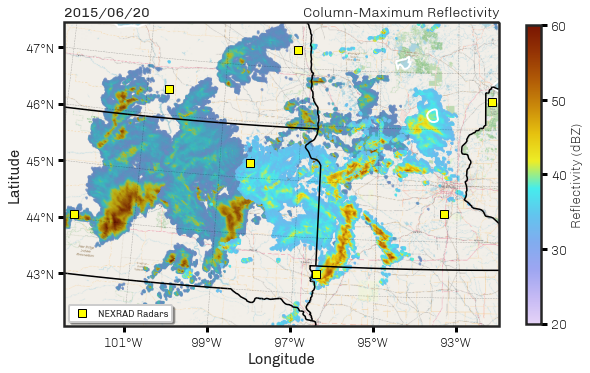

In [16]:
nexrad0620_lon = [-98.2447,-96.4346,-102.4947,-97.1932,-100.4538,-92.1235,-93.3356]
nexrad0620_lat = [45.2721,43.3516,44.0730,47.3140,46.4615,46.5013,44.5056]
xticks,yticks = [-107,-105,-103,-101,-99,-97,-95,-93],[40,41,42,43,44,45,46,47,48]
display_mosaic(gridrad=gridrad2,EXTENT=[-105+2.5,-96+4.05,42.5,47+0.5],loopstep=[1,2],laststep=3,
                   lambert_proj=crs.LambertConformal(central_longitude=-92.0, central_latitude=33.0),
                  cmap_brightdark=[0.5,0.8,0.8],alpha=[0.5,0.7,0.85],plot_domain=[450,950+200,850-100,1350],
                   plot_dlast=[550,950+200,850-100,1350],nexrad_lon=nexrad0620_lon,nexrad_lat=nexrad0620_lat,
                   mobile_lon=None,mobile_lat=None,xticks=xticks,yticks=yticks,date='2015/06/20')

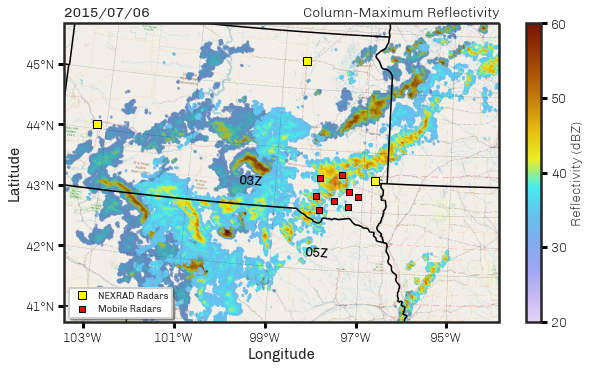

In [20]:
ax = fig.add_subplot(1, 1, 1,projection=crs.LambertConformal(central_longitude=-92.0, central_latitude=33.0))
EXTENT = [-105+1.5,-96+2.05,42.5-1.25,47-1.25]
# Plot the surface
cmap_set = [0.5,0.8,0.8]
alpha = [0.5,0.7,0.85]
for i in [1]:
    wspd_contours = plt.pcolormesh(gridrad2[i]['x']['values'][450:950+200],gridrad2[i]['y']['values'][850-100:1350],
                                   np.ma.masked_less(np.nanmax(
                                       gridrad2[i]['Z_H']['values'],axis=0),30)[850-100:1350,450:950+200],
                                   cmap =cmap_map(lambda x: x*cmap_set[i], pyart.graph.cm.LangRainbow12),
                                   vmin=20,vmax=60,shading='auto',
                                   antialiased=True,transform=crs.PlateCarree(),alpha=alpha[i])
wspd_contours3 = plt.pcolormesh(gridrad2[2]['x']['values'][550:950+200],gridrad2[2]['y']['values'][850-100:1350],
                               np.ma.masked_less(np.nanmax(
                                   gridrad2[2]['Z_H']['values'],axis=0),33)[850-100:1350,550:950+200],
                               cmap =cmap_map(lambda x: x, pyart.graph.cm.LangRainbow12),
                                vmin=20,vmax=60,shading='auto',alpha=0.9,
                               antialiased=True,transform=crs.PlateCarree())

#Radar location
#--------------------------------------------------------------------------------------------------
plt.plot(-98.486389, 45.464722, marker='s', color='yellow', markersize=7.5,mec='k',transform=crs.Geodetic(),lw=0,
        label='NEXRAD Radars')
plt.plot(-96.731667, 43.536389, marker='s', color='yellow', markersize=7.5,mec='k',transform=crs.Geodetic(),lw=0)
plt.plot(-103.228, 44.076, marker='s', color='yellow', markersize=7.5,mec='k',transform=crs.Geodetic(),lw=0)
plt.plot(-100.783611, 46.808333, marker='s', color='yellow', markersize=7.5,mec='k',transform=crs.Geodetic(),lw=0)
plt.plot(-97.0942, 43.2571,marker='s', color='r', markersize=5.5,mec='k',transform=crs.Geodetic(),lw=0,label='Mobile Radars')
plt.plot(-97.3281,43.0825,marker='s', color='r', markersize=5.5,mec='k',transform=crs.Geodetic(),lw=0)
plt.plot(-97.6375,43.1598,marker='s', color='r', markersize=5.5,mec='k',transform=crs.Geodetic(),lw=0)
plt.plot(-97.9812,42.9957,marker='s', color='r', markersize=5.5,mec='k',transform=crs.Geodetic(),lw=0)
plt.plot(-97.3252,43.3284,marker='s', color='r', markersize=5.5,mec='k',transform=crs.Geodetic(),lw=0)
plt.plot(-97.4977,43.6013,marker='s', color='r', markersize=5.5,mec='k',transform=crs.Geodetic(),lw=0)
plt.plot(-98.0047,43.5243,marker='s', color='r', markersize=5.5,mec='k',transform=crs.Geodetic(),lw=0)
plt.plot(-98.0702,43.2254,marker='s', color='r', markersize=5.5,mec='k',transform=crs.Geodetic(),lw=0)

LEGD = ax.legend(fontsize='x-small',\
                 prop=dict(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf',size=9.25), \
                 frameon=True, fancybox=True, shadow=True, loc=3)

fig.canvas.draw()
xticks = [-107,-105,-103,-101,-99,-97,-95,-93]
yticks = [40,41,42,43,44,45,46,47,48]
plt.title('2015/07/06',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)

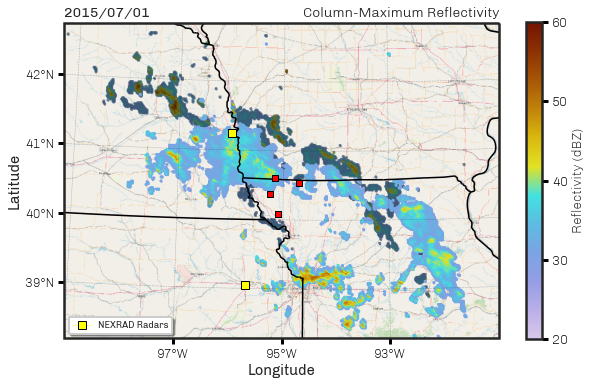

In [13]:
fig = plt.figure(figsize=(11.5-1.75,10.5-1.75))
ax = fig.add_subplot(1, 1, 1,projection=crs.LambertConformal(central_longitude=-94.0, central_latitude=35.0))
EXTENT = [-105+6,-96+5,42.5-4.25,47-4.25]
#ax.set_extent(EXTENT,crs.LambertConformal())
# Plot the surface
cmap_set = [0.5,0.7,0.8]
alpha = [0.7,0.8,0.85]
index = [2,0]
for i in index:
    wspd_contours = plt.pcolormesh(gridrad2[i]['x']['values'][650:1450],gridrad2[i]['y']['values'][250:1050],
                                   np.ma.masked_less(np.nanmax(
                                       gridrad2[i]['Z_H']['values'],axis=0),30)[250:1050,650:1450],
                                   cmap =cmap_map(lambda x: x*cmap_set[i], pyart.graph.cm.LangRainbow12),
                                   vmin=20,vmax=60,shading='auto',
                                   antialiased=True,transform=crs.PlateCarree(),alpha=alpha[i])
wspd_contours3 = plt.pcolormesh(gridrad2[1]['x']['values'][850:1450],gridrad2[1]['y']['values'][250:1050],
                               np.ma.masked_less(np.nanmax(
                                   gridrad2[1]['Z_H']['values'],axis=0),30)[250:1050,850:1450],
                               cmap =cmap_map(lambda x: x*0.95, pyart.graph.cm.LangRainbow12),
                                vmin=20,vmax=60,shading='auto',
                               antialiased=True,transform=crs.PlateCarree())
add_sub_region_box(ax, [-99.75,-97.45,44,45.46],facecolor='none',edgecolor='r',linewidth=1.3)

#Radar location
#--------------------------------------------------------------------------------------------------
plt.plot(-96, 41.25, marker='s', color='yellow', markersize=7.5,mec='k',transform=crs.Geodetic(),lw=0.5,
        label='NEXRAD Radars')
plt.plot(-95.689444,39.055833,  marker='s', color='yellow', markersize=7.5,mec='k',transform=crs.Geodetic(),lw=0.5)
plt.plot(-95.164,40.6099,marker='s', color='r', markersize=5.5,mec='k',transform=crs.Geodetic(),lw=0.5)
plt.plot(-95.0859,40.0903,marker='s', color='r', markersize=5.5,mec='k',transform=crs.Geodetic(),lw=0.5)
plt.plot(-95.2465,40.3788,marker='s', color='r', markersize=5.5,mec='k',transform=crs.Geodetic(),lw=0.5)
plt.plot(-94.7067,40.5365,marker='s', color='r', markersize=5.5,mec='k',transform=crs.Geodetic(),lw=0.5)
plt.plot(-95.0859,40.0903,marker='s', color='r', markersize=5.5,mec='k',transform=crs.Geodetic(),lw=0.5)

fig.canvas.draw()
xticks = [-107,-105,-103,-101,-99,-97,-95,-93]
yticks = [38,39,40,41,42,43,44,45]

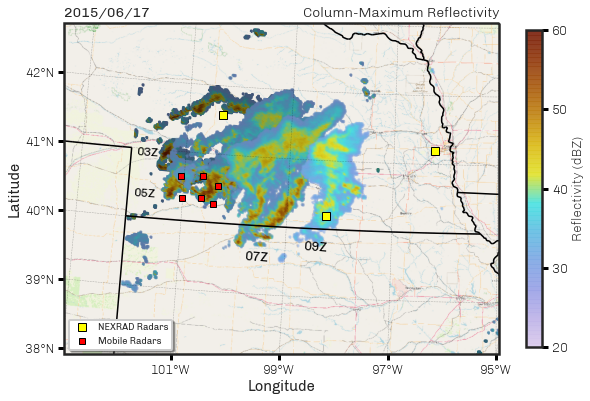

In [12]:
fig = plt.figure(figsize=(11.5-1.75,10.5-1.75))
ax = fig.add_subplot(1, 1, 1,projection=crs.LambertConformal(central_longitude=-94.0, central_latitude=35.0))
# Plot the surface
cmap_set = [0.5,0.7,0.8]
alpha = [1,0.8,0.5]
index = [0,1,2]
for i in index:
    wspd_contours = plt.pcolormesh(gridrad2[i]['x']['values'][650:1450],gridrad2[i]['y']['values'][250:1050],
                                   np.ma.masked_less(np.nanmax(
                                       gridrad2[i]['Z_H']['values'],axis=0),30)[250:1050,650:1450],
                                   cmap =cmap_map(lambda x: x*cmap_set[i], pyart.graph.cm.LangRainbow12),
                                   vmin=20,vmax=60,shading='auto',
                                   antialiased=True,transform=crs.PlateCarree(),alpha=alpha[i])
wspd_contours3 = plt.pcolormesh(gridrad2[3]['x']['values'][650:1450],gridrad2[3]['y']['values'][250:1050],
                               np.ma.masked_less(np.nanmax(
                                   gridrad2[3]['Z_H']['values'],axis=0),30)[250:1050,650:1450],
                               cmap =cmap_map(lambda x: x*0.95, pyart.graph.cm.LangRainbow12),
                                vmin=20,vmax=60,shading='auto',alpha=0.4,
                               antialiased=True,transform=crs.PlateCarree())

#Radar location
#--------------------------------------------------------------------------------------------------
plt.plot(-98.2631,40.1915,marker='s', color='yellow', markersize=7.5,mec='k',transform=crs.Geodetic(),lw=0,
        label='NEXRAD Radars')
plt.plot(-96.2200,41.1913,marker='s', color='yellow', markersize=7.5,mec='k',transform=crs.Geodetic(),lw=0)
plt.plot(-100.3435,41.5728,marker='s', color='yellow', markersize=7.5,mec='k',transform=crs.Geodetic(),lw=0)
plt.plot(-100.653,40.6674, marker='s', color='r', markersize=5.5,mec='k',transform=crs.Geodetic(),lw=0)
plt.plot(-100.35,40.5373,marker='s', color='r', markersize=5.5,mec='k',transform=crs.Geodetic(),lw=0,label='Mobile Radars')
plt.plot(-100.421,40.2787,marker='s', color='r', markersize=5.5,mec='k',transform=crs.Geodetic(),lw=0)
plt.plot(-100.644,40.3416,marker='s', color='r', markersize=5.5,mec='k',transform=crs.Geodetic(),lw=0)
plt.plot(-101.009,40.3213,marker='s', color='r', markersize=5.5,mec='k',transform=crs.Geodetic(),lw=0)
plt.plot(-101.063,40.6473,marker='s', color='r', markersize=5.5,mec='k',transform=crs.Geodetic(),lw=0)
xticks = [-107,-105,-103,-101,-99,-97,-95,-93]
yticks = [38,39,40,41,42,43,44,45]
plt.title('2015/06/17',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)

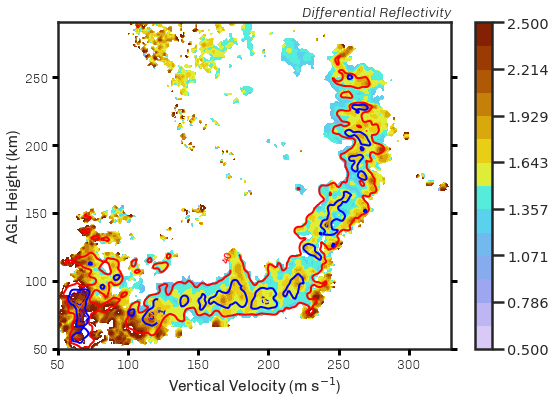

In [44]:
from scipy.ndimage.filters import gaussian_filter
import seaborn as sns
import matplotlib.font_manager as fm
sns.set_style('white',rc={"axes.axisbelow": False})
sns.set_context('poster',font_scale=0.66)
prop = fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf')

fig = plt.figure(figsize=(8.8,6))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
a = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      base.fields['D0']['data'][2,:,:]),3.25),
                   levels=np.linspace(0.5,2.5,15),cmap='pyart_LangRainbow12')
#a = plt.contourf(#np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0.01,
#                                      (base.fields['reflectivity']['data'][2,:,:]),
#                   levels=np.linspace(0,60,15),cmap='pyart_LangRainbow12')
a1 = plt.contour(gaussian_filter(base.fields['reflectivity']['data'][2,:,:],0.87),
            levels=[40],linewidths=2,colors='r')
plt.contour(gaussian_filter(base.fields['reflectivity']['data'][2,:,:],0.87),
            levels=[50],linewidths=1,colors='r',linestyles='--')
a3 = plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')
txt1 = ax.clabel(a1, inline=0.0001, fmt='%1.0f',fontsize=9,manual=[(155,120)])
txt2 = ax.clabel(a3, inline=1e-10, fmt='%1.0f',manual=[(130,75)])
for l in txt1+txt2:
    l.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Medium.ttf',size=10))
plt.colorbar(a)
plt.xlim(50,330)
plt.ylim(50,230+60)
#ax.set_yticks([50,100,150,200])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('AGL Height (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('Vertical Velocity (m s$^{-1}$)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('Differential Reflectivity',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-LightItalic.ttf'),loc='right',
         fontsize=14.03)
plt.show()

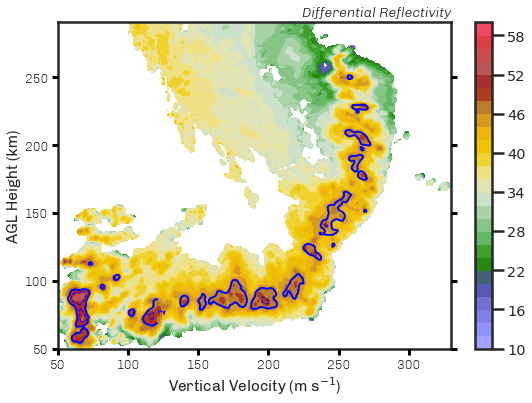

In [45]:
fig = plt.figure(figsize=(8.8,6))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
#a = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][6,:,:]<0,
#                                      base.fields['D0']['data'][6,:,:]),3.25),
#                   levels=np.linspace(0.5,2.5,15),cmap='pyart_LangRainbow12')
a = plt.contourf(#np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0.01,
                                      (base.fields['reflectivity']['data'][2,:,:]),
                   levels=np.linspace(10,60,26),cmap='pyart_Theodore16')
#a = plt.contourf(gaussian_filter(base.fields['reflectivity']['data'][6,:,:],0.87),
#            levels=np.linspace(0,65,27),linewidths=2,cmap='pyart_LangRainbow12')
plt.contour(gaussian_filter(base.fields['reflectivity']['data'][2,:,:],0.87),
            levels=[50],linewidths=1,colors='r',linestyles='--')
a3 = plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')
txt1 = ax.clabel(a1, inline=0.0001, fmt='%1.0f',fontsize=9,manual=[(155,120)])
txt2 = ax.clabel(a3, inline=1e-10, fmt='%1.0f',manual=[(130,75)])
for l in txt1+txt2:
    l.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Medium.ttf',size=10))
plt.colorbar(a)
plt.xlim(50,330)
plt.ylim(50,230+60)
#ax.set_yticks([50,100,150,200])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('AGL Height (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('Vertical Velocity (m s$^{-1}$)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('Differential Reflectivity',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-LightItalic.ttf'),loc='right',
         fontsize=14.03)
plt.show()

### (a) 0620 - 07 UTC

In [6]:
x,y = base.x['data'], base.y['data']
dx = np.abs(x[1]-x[0])
dy = np.abs(y[1]-y[0])
eclass = pyart.retrieve.steiner_conv_strat(base, dx=dx, dy=dy, work_level=2000, refl_field='reflectivity')

In [107]:
len(measure.approximate_polygon(contours_kdp[6], tolerance=1.5))

4

In [120]:
conv_zdr = base.fields['zdr_acorr']['data'][2,:,:]#np.ma.masked_where(eclass['data'] < 2, base.fields['zdr_acorr']['data'][2,:,:])
conv_kdp = base.fields['KDP']['data'][2,:,:]#np.ma.masked_where(eclass['data'] < 2, base.fields['KDP']['data'][2,:,:])
contours = measure.find_contours(conv_zdr,np.nanpercentile(conv_zdr[conv_zdr>0],95))
contours_kdp = measure.find_contours(conv_kdp,np.nanpercentile(conv_kdp[conv_kdp>0],96))

from shapely.geometry import Polygon
dict_area = []
dict_areakdp = []
for contour in contours:
    if len(contour)<6:
        dict_area.append(0)
    else:
        polygon=Polygon(contour)
        dict_area.append(polygon.area)
for contour in contours_kdp:
    if len(contour)<6:
        dict_areakdp.append(0)
    else:
        polygon=Polygon(contour)
        dict_areakdp.append(polygon.area)

large_objectindex = np.where(np.asarray(dict_area)>np.percentile(np.asarray(dict_area),95))
large_objectindexkdp = np.where(np.asarray(dict_areakdp)>np.percentile(np.asarray(dict_areakdp),95))

centroid_obj,centroid_objkdp = [],[]
for obj in np.squeeze(large_objectindex):
    polygon_temp = Polygon(contours[obj])
    centroid_obj.append(polygon_temp.centroid.coords)
for obj in np.squeeze(large_objectindexkdp):
    polygon_temp = Polygon(contours_kdp[obj])
    centroid_objkdp.append(polygon_temp.centroid.coords)

In [121]:
len(dict_areakdp),len(contours_kdp)

(75, 75)

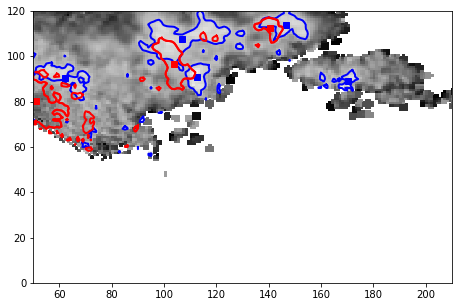

In [123]:
contours = measure.find_contours(conv_zdr,np.nanpercentile(conv_zdr[conv_zdr>0],95))
contours_kdp = measure.find_contours(conv_kdp,np.nanpercentile(conv_kdp[conv_kdp>0],96))

fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
ax.pcolormesh(conv_zdr, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2,color='b')
for contour in contours_kdp:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2,color='r')
for obj in centroid_obj:
    ax.plot(obj.xy[1][0], obj.xy[0][0], linewidth=0,color='b',marker='s')
for obj in centroid_objkdp:
    ax.plot(obj.xy[1][0], obj.xy[0][0], linewidth=0,color='r',marker='s')
for index in np.squeeze(large_objectindexkdp):
    ax.plot(contours_kdp[index][:, 1], contours_kdp[index][:, 0], linewidth=2,color='r')
plt.xlim(50,210)
plt.ylim(0,120)
plt.show()

In [92]:
print(len(centroid_obj),len(centroid_objkdp))

15 8


In [93]:
#min_dist = []
#for objz in centroid_obj:
#    tmp = [((obj.xy[1][0]-objz.xy[1][0])**2+(obj.xy[0][0]-objz.xy[0][0])**2)**(0.5) for obj in centroid_objkdp]
#    tmpM = np.min(tmp)
#    min_dist.append(tmpM)
min_dist = []
for objz in centroid_obj:
    tmp = [((obj.xy[1][0]-objz.xy[1][0])**2+(obj.xy[0][0]-objz.xy[0][0])**2)**(0.5) for obj in centroid_objkdp]
    if any(element<17 for element in tmp):
        tmpM = np.min(tmp)
        min_dist.append(tmpM)
    else:
        min_dist.append(np.nan)
np.nanmedian(np.asarray(min_dist))
#np.median(np.asarray(min_dist)[np.asarray(min_dist)<30])

7.941715444179504

In [42]:
min_dist

[13.108672069279713,
 12.726354007455525,
 16.47046586423579,
 nan,
 nan,
 nan,
 5.654791210845819,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.6872986547131694]

In [ ]:
dist1 = [((obj.xy[1][0]-centroid_obj[0].xy[1][0])**2+(obj.xy[0][0]-centroid_obj[0].xy[0][0])**2)**(0.5) for obj in centroid_objkdp]
dist2 = [((obj.xy[1][0]-centroid_obj[1].xy[1][0])**2+(obj.xy[0][0]-centroid_obj[1].xy[0][0])**2)**(0.5) for obj in centroid_objkdp]
dist3 = [((obj.xy[1][0]-centroid_obj[2].xy[1][0])**2+(obj.xy[0][0]-centroid_obj[2].xy[0][0])**2)**(0.5) for obj in centroid_objkdp]
dist4 = [((obj.xy[1][0]-centroid_obj[3].xy[1][0])**2+(obj.xy[0][0]-centroid_obj[3].xy[0][0])**2)**(0.5) for obj in centroid_objkdp]
dist5 = [((obj.xy[1][0]-centroid_obj[4].xy[1][0])**2+(obj.xy[0][0]-centroid_obj[4].xy[0][0])**2)**(0.5) for obj in centroid_objkdp]
dist6 = [((obj.xy[1][0]-centroid_obj[5].xy[1][0])**2+(obj.xy[0][0]-centroid_obj[5].xy[0][0])**2)**(0.5) for obj in centroid_objkdp]
dist7 = [((obj.xy[1][0]-centroid_obj[6].xy[1][0])**2+(obj.xy[0][0]-centroid_obj[6].xy[0][0])**2)**(0.5) for obj in centroid_objkdp]

print(np.min(dist1),np.min(dist2),np.min(dist3),np.min(dist4),np.min(dist5),np.min(dist6))

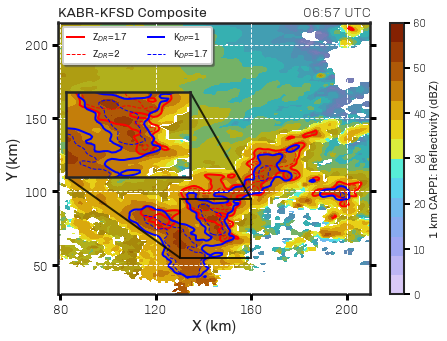

In [10]:
fig = plt.figure(figsize=(7,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
masked_strat = np.ma.masked_where(eclass['data'] == 2, base.fields['reflectivity']['data'][2,:,:])
masked_conv = np.ma.masked_where(eclass['data'] < 2, base.fields['reflectivity']['data'][2,:,:])
shd1 = plt.contourf(masked_conv,levels=np.linspace(0,60,15),
                    cmap=cmap_map(lambda x: x, pyart.graph.cm.LangRainbow12))
plt.contourf(masked_strat,vmin=0,vmax=60,levels=np.linspace(0,60,20),
             cmap=cmap_map(lambda x: x*0.75, pyart.graph.cm.LangRainbow12),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.7],linewidths=2,colors='r')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.93],linewidths=1,colors='r',linestyles='--')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()
h3,_ = cntr3.legend_elements()
h4,_ = cntr4.legend_elements()
LEGD = ax.legend([h1[0],h2[0],h3[0],h4[0]], ['Z$_{DR}$=1.7', 'Z$_{DR}$=2','K$_{DP}$=1','K$_{DP}$=1.7'],
                 fontsize='x-small',\
                 prop=dict(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf',size=9.25), \
                 frameon=True, fancybox=True, shadow=True, loc=2, ncol=2)
CBAR = plt.colorbar(shd1,ticks=[0,10,20,30,40,50,60])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
CBAR.ax.set_yticklabels([0,10,20,30,40,50,60],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Reflectivity (dBZ)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([50,100,150,200])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.set_xticks([80,120,160,200])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.95, color='w', alpha=0.984, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KABR-KFSD Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:57 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([82.5,110,52,57.5], transform=ax.transData)
axins.contourf(masked_conv,levels=np.linspace(0,60,15),
                    cmap=cmap_map(lambda x: x, pyart.graph.cm.LangRainbow12))
axins.contourf(masked_strat,vmin=0,vmax=60,levels=np.linspace(0,60,20),
             cmap=cmap_map(lambda x: x*0.75, pyart.graph.cm.LangRainbow12),alpha=1)
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.7],linewidths=2,colors='r')
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.93],linewidths=1,colors='r',linestyles='--')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 130,160,55,95
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')

ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(79,210)
plt.ylim(30,215)
plt.show()

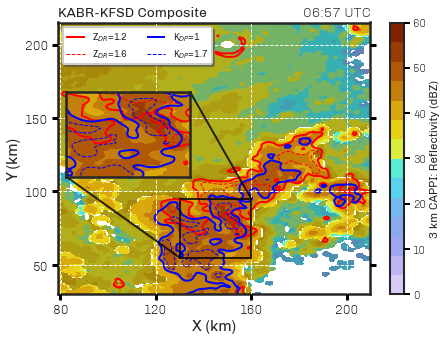

In [13]:
fig = plt.figure(figsize=(7,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
masked_strat = np.ma.masked_where(eclass['data'] == 2, base.fields['reflectivity']['data'][6,:,:])
masked_conv = np.ma.masked_where(eclass['data'] < 2, base.fields['reflectivity']['data'][6,:,:])
shd1 = plt.contourf(masked_conv,levels=np.linspace(0,60,15),
                    cmap=cmap_map(lambda x: x, pyart.graph.cm.LangRainbow12))
plt.contourf(masked_strat,vmin=0,vmax=60,levels=np.linspace(0,60,20),
             cmap=cmap_map(lambda x: x*0.75, pyart.graph.cm.LangRainbow12),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][6,:,:],0.87),
            levels=[1.2],linewidths=2,colors='r')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][6,:,:],0.87),
            levels=[1.6],linewidths=1,colors='r',linestyles='--')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][6,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][6,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()
h3,_ = cntr3.legend_elements()
h4,_ = cntr4.legend_elements()
LEGD = ax.legend([h1[0],h2[0],h3[0],h4[0]], ['Z$_{DR}$=1.2', 'Z$_{DR}$=1.6','K$_{DP}$=1','K$_{DP}$=1.7'],
                 fontsize='x-small',\
                 prop=dict(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf',size=9.25), \
                 frameon=True, fancybox=True, shadow=True, loc=2, ncol=2)
CBAR = plt.colorbar(shd1,ticks=[0,10,20,30,40,50,60])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
CBAR.ax.set_yticklabels([0,10,20,30,40,50,60],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('3 km CAPPI: Reflectivity (dBZ)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([50,100,150,200])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.set_xticks([80,120,160,200])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.95, color='w', alpha=0.984, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KABR-KFSD Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:57 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([82.5,110,52,57.5], transform=ax.transData)
axins.contourf(masked_conv,levels=np.linspace(0,60,15),
                    cmap=cmap_map(lambda x: x, pyart.graph.cm.LangRainbow12))
axins.contourf(masked_strat,vmin=0,vmax=60,levels=np.linspace(0,60,20),
             cmap=cmap_map(lambda x: x*0.75, pyart.graph.cm.LangRainbow12),alpha=1)
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][6,:,:],0.87),
            levels=[1.2],linewidths=2,colors='r')
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][6,:,:],0.87),
            levels=[1.6],linewidths=1,colors='r',linestyles='--')
axins.contour(gaussian_filter(base.fields['KDP']['data'][6,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
axins.contour(gaussian_filter(base.fields['KDP']['data'][6,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 130,160,55,95
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')

ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(79,210)
plt.ylim(30,215)
plt.show()

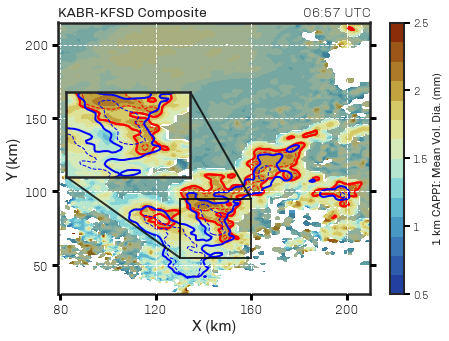

In [11]:
# Mean Volume Diameter (Bringi et al. 2013)
#------------------------------------------------------------------------------------
fig = plt.figure(figsize=(7,5))
from palettable.scientific.diverging import Roma_15_r
# plot super resolution reflectivity
ax = fig.add_subplot(111)
masked_strat = np.ma.masked_where(eclass['data'] == 2, base.fields['D0']['data'][2,:,:])
masked_conv = np.ma.masked_where(eclass['data'] < 2, base.fields['D0']['data'][2,:,:])
shd1 = plt.contourf(masked_conv,levels=np.linspace(0.5,2.5,15),
                    cmap=cmap_map(lambda x: x, Roma_15_r.mpl_colormap))
plt.contourf(masked_strat,vmin=0,vmax=3,levels=np.linspace(0.5,2.5,15),
             cmap=cmap_map(lambda x: x*0.75, Roma_15_r.mpl_colormap),alpha=1)
plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.7],linewidths=2,colors='r')
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.7],linewidths=2,colors='r')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.93],linewidths=1,colors='r',linestyles='--')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
#h1,_ = cntr1.legend_elements()
#h2,_ = cntr2.legend_elements()
#h3,_ = cntr3.legend_elements()
#h4,_ = cntr4.legend_elements()
#LEGD = ax.legend([h1[0],h2[0],h3[0],h4[0]], ['Z$_{DR}$=1.7', 'Z$_{DR}$=2','K$_{DP}$=1','K$_{DP}$=1.7'],
#                 fontsize='x-small',\
#                 prop=dict(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf',size=9.25), \
#                 frameon=True, fancybox=True, shadow=True, loc=2, ncol=2)
CBAR = plt.colorbar(shd1,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Mean Vol. Dia. (mm)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([50,100,150,200])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.set_xticks([80,120,160,200])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.95, color='w', alpha=0.984, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KABR-KFSD Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:57 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([82.5,110,52,57.5], transform=ax.transData)
shd1 = axins.contourf(masked_conv,levels=np.linspace(0.5,2.5,15),
                    cmap=cmap_map(lambda x: x, Roma_15_r.mpl_colormap))
axins.contourf(masked_strat,vmin=0,vmax=3,levels=np.linspace(0.5,2.5,15),
             cmap=cmap_map(lambda x: x*0.75, Roma_15_r.mpl_colormap),alpha=1)
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.7],linewidths=2,colors='r')
cntr1=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.7],linewidths=2,colors='r')
cntr2=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.93],linewidths=1,colors='r',linestyles='--')
cntr3=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 130,160,55,95
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(79,210)
plt.ylim(30,215)
plt.show()

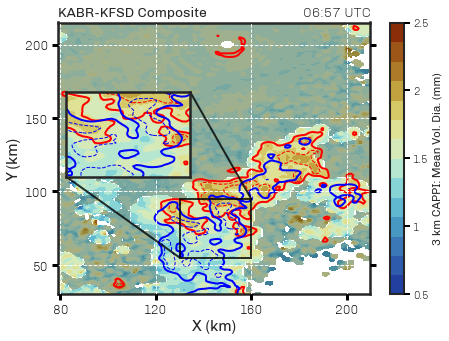

In [15]:
# Mean Volume Diameter (Bringi et al. 2013)
#------------------------------------------------------------------------------------
fig = plt.figure(figsize=(7,5))
from palettable.scientific.diverging import Roma_15_r
# plot super resolution reflectivity
ax = fig.add_subplot(111)
masked_strat = np.ma.masked_where(eclass['data'] == 2, base.fields['D0']['data'][6,:,:])
masked_conv = np.ma.masked_where(eclass['data'] < 2, base.fields['D0']['data'][6,:,:])
shd1 = plt.contourf(masked_conv,levels=np.linspace(0.5,2.5,15),
                    cmap=cmap_map(lambda x: x, Roma_15_r.mpl_colormap))
plt.contourf(masked_strat,vmin=0,vmax=3,levels=np.linspace(0.5,2.5,15),
             cmap=cmap_map(lambda x: x*0.75, Roma_15_r.mpl_colormap),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][6,:,:],0.87),
            levels=[1.2],linewidths=2,colors='r')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][6,:,:],0.87),
            levels=[1.6],linewidths=1,colors='r',linestyles='--')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][6,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][6,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('3 km CAPPI: Mean Vol. Dia. (mm)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([50,100,150,200])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.set_xticks([80,120,160,200])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.95, color='w', alpha=0.984, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KABR-KFSD Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:57 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([82.5,110,52,57.5], transform=ax.transData)
shd1 = axins.contourf(masked_conv,levels=np.linspace(0.5,2.5,15),
                    cmap=cmap_map(lambda x: x, Roma_15_r.mpl_colormap))
axins.contourf(masked_strat,vmin=0,vmax=3,levels=np.linspace(0.5,2.5,15),
             cmap=cmap_map(lambda x: x*0.75, Roma_15_r.mpl_colormap),alpha=1)
cntr1=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][6,:,:],0.87),
            levels=[1.2],linewidths=2,colors='r')
cntr2=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][6,:,:],0.87),
            levels=[1.6],linewidths=1,colors='r',linestyles='--')
cntr3=axins.contour(gaussian_filter(base.fields['KDP']['data'][6,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=axins.contour(gaussian_filter(base.fields['KDP']['data'][6,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 130,160,55,95
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(79,210)
plt.ylim(30,215)
plt.show()

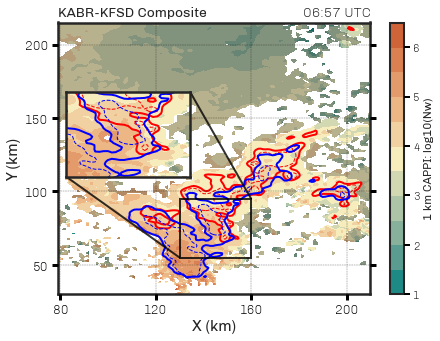

In [28]:
# Mean Volume Diameter (Bringi et al. 2013)
#------------------------------------------------------------------------------------
fig = plt.figure(figsize=(7,5))
# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.cartocolors.diverging import Geyser_7
masked_strat = np.ma.masked_where(eclass['data'] == 2, (base.fields['Nw']['data'][2,:,:]))
masked_conv = np.ma.masked_where(eclass['data'] < 2, (base.fields['Nw']['data'][2,:,:]))
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                                            masked_conv),100),levels=np.linspace(1,6.5,12),
                        cmap=cmap_map(lambda x: x, Geyser_7.mpl_colormap))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                          masked_strat),8),levels=np.linspace(1,6.5,12),
                 cmap=cmap_map(lambda x: x*0.75, Geyser_7.mpl_colormap),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.7],linewidths=2,colors='r')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.93],linewidths=1,colors='r',linestyles='--')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
#h1,_ = cntr1.legend_elements()
#h2,_ = cntr2.legend_elements()
#h3,_ = cntr3.legend_elements()
#h4,_ = cntr4.legend_elements()
#LEGD = ax.legend([h1[0],h2[0],h3[0],h4[0]], ['Z$_{DR}$=1.7', 'Z$_{DR}$=2','K$_{DP}$=1','K$_{DP}$=1.7'],
#                 fontsize='x-small',\
#                 prop=dict(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf',size=9.25), \
#                 frameon=True, fancybox=True, shadow=True, loc=2, ncol=2)
CBAR = plt.colorbar(shd1)#,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: log10(Nw)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([50,100,150,200,250,300])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.45, color='k', alpha=0.584, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
plt.title('KABR-KFSD Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:57 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([82.5,110,52,57.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                                            masked_conv),100),levels=np.linspace(1,6.5,12),
                        cmap=cmap_map(lambda x: x, Geyser_7.mpl_colormap))
axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                                            masked_strat),100),levels=np.linspace(1,6.5,12),
                        cmap=cmap_map(lambda x: x*0.75, Geyser_7.mpl_colormap))
cntr1=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.7],linewidths=2,colors='r')
cntr2=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.93],linewidths=1,colors='r',linestyles='--')
cntr3=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 130,160,55,95
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(79,210)
plt.ylim(30,215)
plt.show()

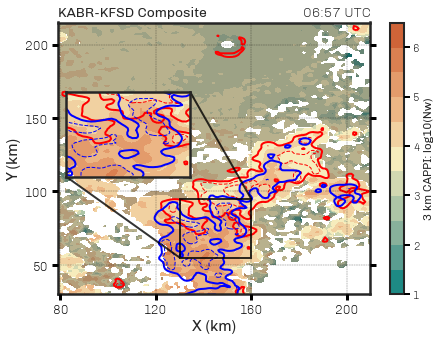

In [17]:
# Mean Volume Diameter (Bringi et al. 2013)
#------------------------------------------------------------------------------------
fig = plt.figure(figsize=(7,5))
# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.cartocolors.diverging import Geyser_7
masked_strat = np.ma.masked_where(eclass['data'] == 2, (base.fields['Nw']['data'][6,:,:]))
masked_conv = np.ma.masked_where(eclass['data'] < 2, (base.fields['Nw']['data'][6,:,:]))
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][6,:,:]<0,
                                                            masked_conv),100),levels=np.linspace(1,6.5,12),
                        cmap=cmap_map(lambda x: x, Geyser_7.mpl_colormap))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][6,:,:]<0,
                                          masked_strat),8),levels=np.linspace(1,6.5,12),
                 cmap=cmap_map(lambda x: x*0.75, Geyser_7.mpl_colormap),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][6,:,:],0.87),
            levels=[1.2],linewidths=2,colors='r')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][6,:,:],0.87),
            levels=[1.6],linewidths=1,colors='r',linestyles='--')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][6,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][6,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1)#,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('3 km CAPPI: log10(Nw)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([50,100,150,200,250,300])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.45, color='k', alpha=0.584, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
plt.title('KABR-KFSD Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:57 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([82.5,110,52,57.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                                            masked_conv),100),levels=np.linspace(1,6.5,12),
                        cmap=cmap_map(lambda x: x, Geyser_7.mpl_colormap))
axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                                            masked_strat),100),levels=np.linspace(1,6.5,12),
                        cmap=cmap_map(lambda x: x*0.75, Geyser_7.mpl_colormap))
cntr1=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][6,:,:],0.87),
            levels=[1.2],linewidths=2,colors='r')
cntr2=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][6,:,:],0.87),
            levels=[1.6],linewidths=1,colors='r',linestyles='--')
cntr3=axins.contour(gaussian_filter(base.fields['KDP']['data'][6,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=axins.contour(gaussian_filter(base.fields['KDP']['data'][6,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 130,160,55,95
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(79,210)
plt.ylim(30,215)
plt.show()

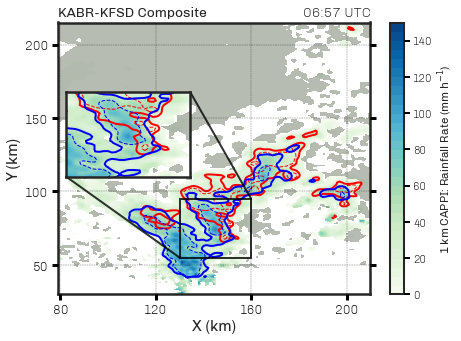

In [39]:
# Hybrid Rain Rate
#------------------------------------------------------------------------------------
fig = plt.figure(figsize=(7,5))
# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.scientific.diverging import Roma_15_r
masked_strat = np.ma.masked_where(eclass['data'] == 2, (base.fields['rain_blend']['data'][2,:,:]))
masked_conv = np.ma.masked_where(eclass['data'] < 2, (base.fields['rain_blend']['data'][2,:,:]))
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),400),levels=np.linspace(0,150,31),
                        cmap=cmap_map(lambda x: x, matplotlib.cm.GnBu))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),400),levels=np.linspace(0,150,31),
                 cmap=cmap_map(lambda x: x*0.75, matplotlib.cm.GnBu),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.7],linewidths=2,colors='r')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.93],linewidths=1,colors='r',linestyles='--')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
#h1,_ = cntr1.legend_elements()
#h2,_ = cntr2.legend_elements()
#h3,_ = cntr3.legend_elements()
#h4,_ = cntr4.legend_elements()
#LEGD = ax.legend([h1[0],h2[0],h3[0],h4[0]], ['Z$_{DR}$=1.7', 'Z$_{DR}$=2','K$_{DP}$=1','K$_{DP}$=1.7'],
#                 fontsize='x-small',\
#                 prop=dict(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf',size=9.25), \
#                 frameon=True, fancybox=True, shadow=True, loc=2, ncol=2)
CBAR = plt.colorbar(shd1)#,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Rainfall Rate (mm h$^{-1}$)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([50,100,150,200,250,300])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.45, color='k', alpha=0.584, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KABR-KFSD Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:57 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([82.5,110,52,57.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),400),levels=np.linspace(0,160,33),
                    cmap=cmap_map(lambda x: x, matplotlib.cm.GnBu))
axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),400),levels=np.linspace(0,160,33),
                 cmap=cmap_map(lambda x: x*0.75, matplotlib.cm.GnBu),alpha=1)
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.7],linewidths=2,colors='r')
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.93],linewidths=1,colors='r',linestyles='--')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 130,160,55,95
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(79,210)
plt.ylim(30,215)
plt.show()

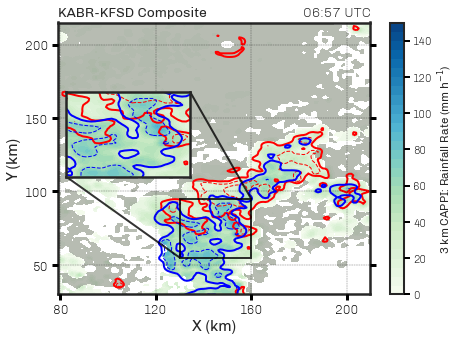

In [18]:
# Hybrid Rain Rate
#------------------------------------------------------------------------------------
fig = plt.figure(figsize=(7,5))
# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.scientific.diverging import Roma_15_r
masked_strat = np.ma.masked_where(eclass['data'] == 2, (base.fields['rain_blend']['data'][6,:,:]))
masked_conv = np.ma.masked_where(eclass['data'] < 2, (base.fields['rain_blend']['data'][6,:,:]))
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][6,:,:]<0,
                                      masked_conv),400),levels=np.linspace(0,150,31),
                        cmap=cmap_map(lambda x: x, matplotlib.cm.GnBu))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][6,:,:]<0,
                                      masked_strat),400),levels=np.linspace(0,150,31),
                 cmap=cmap_map(lambda x: x*0.75, matplotlib.cm.GnBu),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][6,:,:],0.87),
            levels=[1.2],linewidths=2,colors='r')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][6,:,:],0.87),
            levels=[1.6],linewidths=1,colors='r',linestyles='--')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][6,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][6,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1)#,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('3 km CAPPI: Rainfall Rate (mm h$^{-1}$)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([50,100,150,200,250,300])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.45, color='k', alpha=0.584, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KABR-KFSD Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:57 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([82.5,110,52,57.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][6,:,:]<0,
                                      masked_conv),400),levels=np.linspace(0,160,33),
                    cmap=cmap_map(lambda x: x, matplotlib.cm.GnBu))
axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][6,:,:]<0,
                                      masked_strat),400),levels=np.linspace(0,160,33),
                 cmap=cmap_map(lambda x: x*0.75, matplotlib.cm.GnBu),alpha=1)
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][6,:,:],0.87),
            levels=[1.2],linewidths=2,colors='r')
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][6,:,:],0.87),
            levels=[1.6],linewidths=1,colors='r',linestyles='--')
axins.contour(gaussian_filter(base.fields['KDP']['data'][6,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
axins.contour(gaussian_filter(base.fields['KDP']['data'][6,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 130,160,55,95
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(79,210)
plt.ylim(30,215)
plt.show()

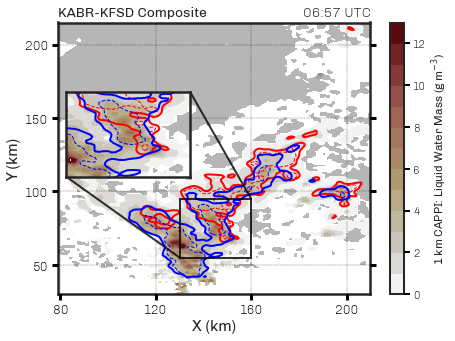

In [40]:
# Hybrid Rain Rate
#------------------------------------------------------------------------------------
from palettable.scientific.sequential import Bilbao_18
fig = plt.figure(figsize=(7,5))
# plot super resolution reflectivity
ax = fig.add_subplot(111)
masked_strat = np.ma.masked_where(eclass['data'] == 2, (base.fields['MW']['data'][2,:,:]))
masked_conv = np.ma.masked_where(eclass['data'] < 2, (base.fields['MW']['data'][2,:,:]))
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0,13,14),
                        cmap=cmap_map(lambda x: x, Bilbao_18.mpl_colormap))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),100),levels=np.linspace(0,13,14),
                 cmap=cmap_map(lambda x: x*0.75, Bilbao_18.mpl_colormap),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.7],linewidths=2,colors='r')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.93],linewidths=1,colors='r',linestyles='--')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1)#,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Liquid Water Mass (g m$^{-3}$)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([50,100,150,200,250,300])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.45, color='k', alpha=0.584, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KABR-KFSD Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:57 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([82.5,110,52,57.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0,13.3,14),
                    cmap=cmap_map(lambda x: x, Bilbao_18.mpl_colormap))
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),100),levels=np.linspace(0,13.3,14),
                    cmap=cmap_map(lambda x: x*0.75, Bilbao_18.mpl_colormap))
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.7],linewidths=2,colors='r')
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.93],linewidths=1,colors='r',linestyles='--')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 130,160,55,95
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(79,210)
plt.ylim(30,215)
plt.show()

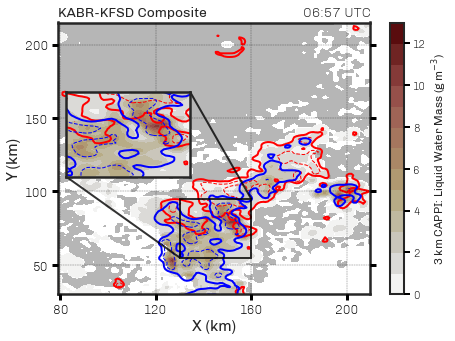

In [19]:
# Hybrid Rain Rate
#------------------------------------------------------------------------------------
from palettable.scientific.sequential import Bilbao_18
fig = plt.figure(figsize=(7,5))
# plot super resolution reflectivity
ax = fig.add_subplot(111)
masked_strat = np.ma.masked_where(eclass['data'] == 2, (base.fields['MW']['data'][6,:,:]))
masked_conv = np.ma.masked_where(eclass['data'] < 2, (base.fields['MW']['data'][6,:,:]))
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][6,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0,13,14),
                        cmap=cmap_map(lambda x: x, Bilbao_18.mpl_colormap))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][6,:,:]<0,
                                      masked_strat),100),levels=np.linspace(0,13,14),
                 cmap=cmap_map(lambda x: x*0.75, Bilbao_18.mpl_colormap),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][6,:,:],0.87),
            levels=[1.2],linewidths=2,colors='r')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][6,:,:],0.87),
            levels=[1.6],linewidths=1,colors='r',linestyles='--')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][6,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][6,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1)#,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('3 km CAPPI: Liquid Water Mass (g m$^{-3}$)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([50,100,150,200,250,300])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.45, color='k', alpha=0.584, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KABR-KFSD Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:57 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([82.5,110,52,57.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][6,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0,13.3,14),
                    cmap=cmap_map(lambda x: x, Bilbao_18.mpl_colormap))
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][6,:,:]<0,
                                      masked_strat),100),levels=np.linspace(0,13.3,14),
                    cmap=cmap_map(lambda x: x*0.75, Bilbao_18.mpl_colormap))
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][6,:,:],0.87),
            levels=[1.2],linewidths=2,colors='r')
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][6,:,:],0.87),
            levels=[1.6],linewidths=1,colors='r',linestyles='--')
axins.contour(gaussian_filter(base.fields['KDP']['data'][6,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
axins.contour(gaussian_filter(base.fields['KDP']['data'][6,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 130,160,55,95
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(79,210)
plt.ylim(30,215)
plt.show()

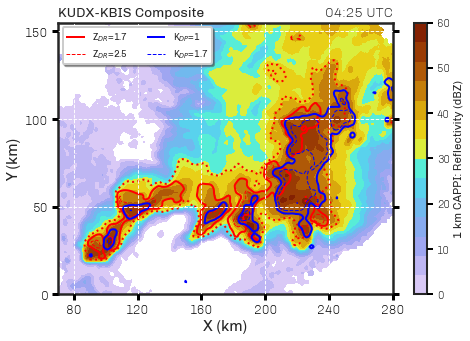

In [44]:
fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
masked_strat = np.ma.masked_where(eclass['data'] == 2, base.fields['reflectivity']['data'][2,:,:])
masked_conv = np.ma.masked_where(eclass['data'] < 2, base.fields['reflectivity']['data'][2,:,:])
shd1 = plt.contourf(base.fields['reflectivity']['data'][2,:,:],levels=np.linspace(0,60,15),
                    cmap=cmap_map(lambda x: x, pyart.graph.cm.LangRainbow12))
#plt.contourf(np.ma.masked_less(masked_strat,3),vmin=0,vmax=60,levels=np.linspace(0,60,20),
#             cmap=cmap_map(lambda x: x*0.95, pyart.graph.cm.LangRainbow12),alpha=1)
cntr0=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[0],linewidths=2,colors='#ff0000',linestyles='dotted')
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.7],linewidths=2,colors='r')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[2.5],linewidths=1,colors='r',linestyles='--')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()
h3,_ = cntr3.legend_elements()
h4,_ = cntr4.legend_elements()
LEGD = ax.legend([h1[0],h2[0],h3[0],h4[0]], ['Z$_{DR}$=1.7', 'Z$_{DR}$=2.5','K$_{DP}$=1','K$_{DP}$=1.7'],
                 fontsize='x-small',\
                 prop=dict(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf',size=9.25), \
                 frameon=True, fancybox=True, shadow=True, loc=2, ncol=2)
CBAR = plt.colorbar(shd1,ticks=[0,10,20,30,40,50,60])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
CBAR.ax.set_yticklabels([0,10,20,30,40,50,60],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Reflectivity (dBZ)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([0,50,100,150,200])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.set_xticks([80,120,160,200,240,280])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.95, color='w', alpha=0.984, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
plt.title('KOAX-KTWX Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:04 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([115,110,52,60.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0,150,31),
                    cmap=cmap_map(lambda x: x, matplotlib.cm.GnBu))
#axins.contourf(masked_strat,vmin=0,vmax=3,levels=np.linspace(0,2.5,15),
#             cmap=cmap_map(lambda x: x*0.75, Roma_15_r.mpl_colormap),alpha=1)
cntr1=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[0.5],linewidths=2,colors='r')
cntr2=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr3=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 77,110,190,215
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(50,250)
plt.ylim(100,305)
plt.show()

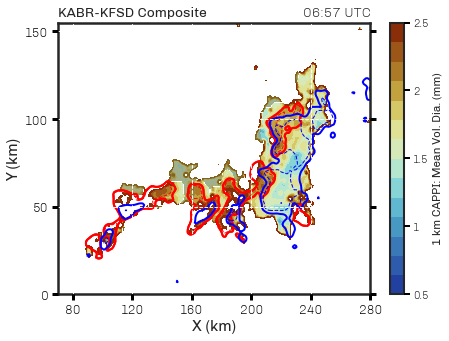

In [10]:
# Mean Volume Diameter (Bringi et al. 2013)
#------------------------------------------------------------------------------------
fig = plt.figure(figsize=(7,5))
from palettable.scientific.diverging import Roma_15_r
# plot super resolution reflectivity
ax = fig.add_subplot(111)
masked_strat = np.ma.masked_where(eclass['data'] == 2, base.fields['D0']['data'][2,:,:])
masked_conv = np.ma.masked_where(eclass['data'] < 2, base.fields['D0']['data'][2,:,:])
shd1 = plt.contourf(masked_conv,levels=np.linspace(0.5,2.5,15),
                    cmap=cmap_map(lambda x: x, Roma_15_r.mpl_colormap))
plt.contourf(masked_strat,vmin=0,vmax=3,levels=np.linspace(0.5,2.5,15),
             cmap=cmap_map(lambda x: x*0.75, Roma_15_r.mpl_colormap),alpha=1)
plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.7],linewidths=2,colors='r')
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.7],linewidths=2,colors='r')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.93],linewidths=1,colors='r',linestyles='--')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
#h1,_ = cntr1.legend_elements()
#h2,_ = cntr2.legend_elements()
#h3,_ = cntr3.legend_elements()
#h4,_ = cntr4.legend_elements()
#LEGD = ax.legend([h1[0],h2[0],h3[0],h4[0]], ['Z$_{DR}$=1.7', 'Z$_{DR}$=2','K$_{DP}$=1','K$_{DP}$=1.7'],
#                 fontsize='x-small',\
#                 prop=dict(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf',size=9.25), \
#                 frameon=True, fancybox=True, shadow=True, loc=2, ncol=2)
CBAR = plt.colorbar(shd1,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Mean Vol. Dia. (mm)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([0,50,100,150,200])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.set_xticks([80,120,160,200,240,280])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.95, color='w', alpha=0.984, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KABR-KFSD Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:57 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)

# inset axes....
#axins = ax.inset_axes([82.5,110,52,57.5], transform=ax.transData)
#shd1 = axins.contourf(masked_conv,levels=np.linspace(0.5,2.5,15),
#                    cmap=cmap_map(lambda x: x, Roma_15_r.mpl_colormap))
#axins.contourf(masked_strat,vmin=0,vmax=3,levels=np.linspace(0.5,2.5,15),
#             cmap=cmap_map(lambda x: x*0.75, Roma_15_r.mpl_colormap),alpha=1)
#axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
#            levels=[1.7],linewidths=2,colors='r')
#cntr1=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
#            levels=[1.7],linewidths=2,colors='r')
#cntr2=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
#            levels=[1.93],linewidths=1,colors='r',linestyles='--')
#cntr3=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
#            levels=[1],linewidths=2,colors='b')
#cntr4=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
#            levels=[1.75],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
#x1, x2, y1, y2 = 130,160,55,95
#axins.set_xlim(x1, x2)
#axins.set_ylim(y1, y2)
#axins.set_xticklabels('')
#axins.set_yticklabels('')
#ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(70,280)
plt.ylim(0,155)
plt.show()

### (II) 0701

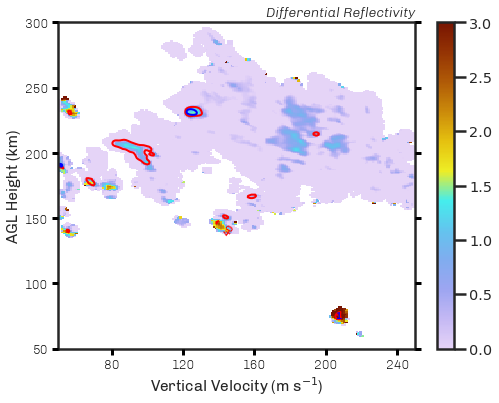

In [5]:
from scipy.ndimage.filters import gaussian_filter
import seaborn as sns
import matplotlib.font_manager as fm
sns.set_style('white',rc={"axes.axisbelow": False})
sns.set_context('poster',font_scale=0.66)
prop = fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf')

fig = plt.figure(figsize=(8,6))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
a = plt.pcolormesh(base.fields['zdr_acorr']['data'][2,:,:],vmin=0,vmax=3,cmap='pyart_LangRainbow12')
a1 = plt.contour(gaussian_filter(base.fields['reflectivity']['data'][2,:,:],0.87),
            levels=[40],linewidths=2,colors='r')
plt.contour(gaussian_filter(base.fields['reflectivity']['data'][2,:,:],0.87),
            levels=[50],linewidths=1,colors='r',linestyles='--')
a3 = plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')
txt1 = ax.clabel(a1, inline=0.0001, fmt='%1.0f',fontsize=9,manual=[(155,120)])
txt2 = ax.clabel(a3, inline=1e-10, fmt='%1.0f',manual=[(130,75)])
for l in txt1+txt2:
    l.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Medium.ttf',size=10))
#ax.clabel(a2, inline=0.0001, fmt='%1.0f',fontsize=8,manual=[(145,80)])
#ax.clabel(a3, inline=True, fmt='%1.1f',fontsize=6,manual_location=[
#    (-1, -1.4))
#ax.clabel(a4, inline=True, fmt='%1.1f',fontsize=6,manual_location=[
#    (-1, -1.4))
plt.colorbar(a)
plt.xlim(50,250)
plt.ylim(100,300)
ax.set_yticks([50,100,150,200,250,300])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('AGL Height (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('Vertical Velocity (m s$^{-1}$)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('Differential Reflectivity',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-LightItalic.ttf'),loc='right',
         fontsize=14.03)
plt.show()

In [6]:
x,y = base.x['data'], base.y['data']
dx = np.abs(x[1]-x[0])
dy = np.abs(y[1]-y[0])
eclass = pyart.retrieve.steiner_conv_strat(base, dx=dx, dy=dy, work_level=2000, refl_field='reflectivity')

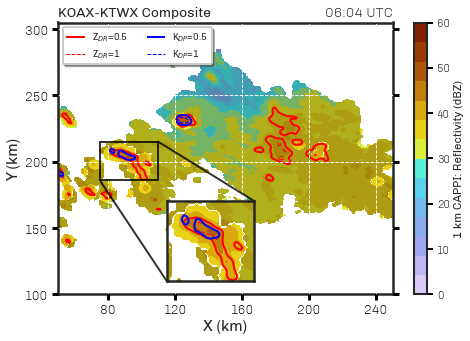

In [7]:
fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
masked_strat = np.ma.masked_where(eclass['data'] == 2, base.fields['reflectivity']['data'][2,:,:])
masked_conv = np.ma.masked_where(eclass['data'] < 2, base.fields['reflectivity']['data'][2,:,:])
shd1 = plt.contourf(masked_conv,levels=np.linspace(0,60,15),
                    cmap=cmap_map(lambda x: x, pyart.graph.cm.LangRainbow12))
plt.contourf(np.ma.masked_less(masked_strat,3),vmin=0,vmax=60,levels=np.linspace(0,60,20),
             cmap=cmap_map(lambda x: x*0.75, pyart.graph.cm.LangRainbow12),alpha=1)
#cntr0=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
#            levels=[0.5],linewidths=2,colors='#ff0000',linestyles='dotted')
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[0.5],linewidths=2,colors='r')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()
h3,_ = cntr3.legend_elements()
h4,_ = cntr4.legend_elements()
LEGD = ax.legend([h1[0],h2[0],h3[0],h4[0]], ['Z$_{DR}$=0.5', 'Z$_{DR}$=1','K$_{DP}$=0.5','K$_{DP}$=1'],
                 fontsize='x-small',\
                 prop=dict(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf',size=9.25), \
                 frameon=True, fancybox=True, shadow=True, loc=2, ncol=2)
CBAR = plt.colorbar(shd1,ticks=[0,10,20,30,40,50,60])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
CBAR.ax.set_yticklabels([0,10,20,30,40,50,60],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Reflectivity (dBZ)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([50,100,150,200,250,300])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.95, color='w', alpha=0.984, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KOAX-KTWX Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:04 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([115,110,52,60.5], transform=ax.transData)
shd1 = axins.contourf(masked_conv,levels=np.linspace(0,60,15),
                    cmap=cmap_map(lambda x: x, pyart.graph.cm.LangRainbow12))
axins.contourf(np.ma.masked_less(masked_strat,3),vmin=0,vmax=60,levels=np.linspace(0,60,20),
             cmap=cmap_map(lambda x: x*0.75, pyart.graph.cm.LangRainbow12),alpha=1)
#cntr0=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
#            levels=[0.5],linewidths=2,colors='#ff0000',linestyles='dotted')
cntr1=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[0.5],linewidths=2,colors='r')
cntr2=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr3=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 75,110,186,215
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(50,250)
plt.ylim(100,305)
plt.show()

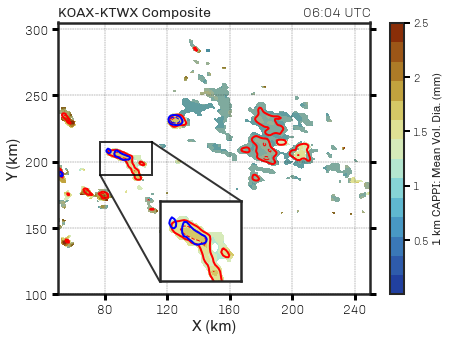

In [7]:
# Mean Volume Diameter (Bringi et al. 2013)
#------------------------------------------------------------------------------------
fig = plt.figure(figsize=(7,5))
# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.scientific.diverging import Roma_15_r
from palettable.cartocolors.diverging import Geyser_7
masked_strat = np.ma.masked_where(eclass['data'] == 2, base.fields['D0']['data'][2,:,:])
masked_conv = np.ma.masked_where(eclass['data'] < 2, base.fields['D0']['data'][2,:,:])
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),3.25),levels=np.linspace(0,2.5,15),
                    cmap=cmap_map(lambda x: x, Roma_15_r.mpl_colormap))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),3.25),vmin=0,vmax=3,levels=np.linspace(0,2.5,15),
             cmap=cmap_map(lambda x: x*0.75, Roma_15_r.mpl_colormap),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[0.5],linewidths=2,colors='r')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
#h1,_ = cntr1.legend_elements()
#h2,_ = cntr2.legend_elements()
#h3,_ = cntr3.legend_elements()
#h4,_ = cntr4.legend_elements()
#LEGD = ax.legend([h1[0],h2[0],h3[0],h4[0]], ['Z$_{DR}$=1.7', 'Z$_{DR}$=2','K$_{DP}$=1','K$_{DP}$=1.7'],
#                 fontsize='x-small',\
#                 prop=dict(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf',size=9.25), \
#                 frameon=True, fancybox=True, shadow=True, loc=2, ncol=2)
CBAR = plt.colorbar(shd1,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Mean Vol. Dia. (mm)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([50,100,150,200,250,300])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.45, color='k', alpha=0.584, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KOAX-KTWX Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:04 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)

# inset axes....
axins = ax.inset_axes([115,110,52,60.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),3.25),levels=np.linspace(0,2.5,15),
                    cmap=cmap_map(lambda x: x, Roma_15_r.mpl_colormap))
axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),3.25),vmin=0,vmax=3,levels=np.linspace(0,2.5,15),
             cmap=cmap_map(lambda x: x*0.75, Roma_15_r.mpl_colormap),alpha=1)
cntr1=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[0.5],linewidths=2,colors='r')
cntr2=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr3=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 77,110,190,215
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(50,250)
plt.ylim(100,305)
plt.show()

In [19]:
base.fields.keys()

dict_keys(['reflectivity', 'zdr_acorr', 'KDP', 'cross_correlation_ratio', 'MW', 'MI', 'D0', 'Nw', 'mu', 'rain_blend', 'ZDP', 'FI', 'temp_radiosonde', 'z_radiosonde', 'spectrum_width', 'SNR', 'ROI', 'Thurai_class', 'PID'])

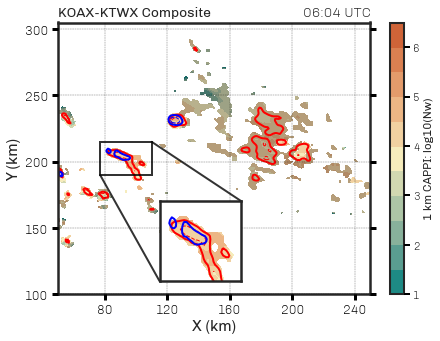

In [8]:
# Mean Volume Diameter (Bringi et al. 2013)
#------------------------------------------------------------------------------------
fig = plt.figure(figsize=(7,5))
# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.scientific.diverging import Roma_15_r
masked_strat = np.ma.masked_where(eclass['data'] == 2, (base.fields['Nw']['data'][2,:,:]))
masked_conv = np.ma.masked_where(eclass['data'] < 2, (base.fields['Nw']['data'][2,:,:]))
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                                            masked_conv),100),levels=np.linspace(1,6.5,12),
                        cmap=cmap_map(lambda x: x, Geyser_7.mpl_colormap))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                          masked_strat),8),levels=np.linspace(1,6.5,12),
                 cmap=cmap_map(lambda x: x*0.75, Geyser_7.mpl_colormap),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[0.5],linewidths=2,colors='r')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1)#,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: log10(Nw)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([50,100,150,200,250,300])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.45, color='k', alpha=0.584, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KOAX-KTWX Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:04 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)

# inset axes....
axins = ax.inset_axes([115,110,52,60.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                                            masked_conv),100),levels=np.linspace(1,6.5,12),
                        cmap=cmap_map(lambda x: x, Geyser_7.mpl_colormap))
axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                          masked_strat),8),levels=np.linspace(1,6.5,12),
                 cmap=cmap_map(lambda x: x*0.75, Geyser_7.mpl_colormap),alpha=1)
cntr1=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[0.5],linewidths=2,colors='r')
cntr2=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr3=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 77,110,190,215
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(50,250)
plt.ylim(100,305)
plt.show()

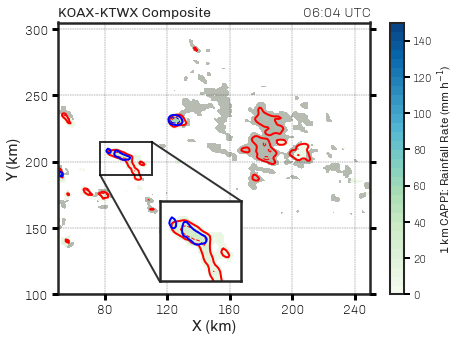

In [52]:
# Hybrid Rain Rate
#------------------------------------------------------------------------------------
fig = plt.figure(figsize=(7,5))
# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.scientific.diverging import Roma_15_r
masked_strat = np.ma.masked_where(eclass['data'] == 2, (base.fields['rain_blend']['data'][2,:,:]))
masked_conv = np.ma.masked_where(eclass['data'] < 2, (base.fields['rain_blend']['data'][2,:,:]))
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0,150,31),
                        cmap=cmap_map(lambda x: x, matplotlib.cm.GnBu))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),100),levels=np.linspace(0,150,31),
                 cmap=cmap_map(lambda x: x*0.75, matplotlib.cm.GnBu),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[0.5],linewidths=2,colors='r')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
#h1,_ = cntr1.legend_elements()
#h2,_ = cntr2.legend_elements()
#h3,_ = cntr3.legend_elements()
#h4,_ = cntr4.legend_elements()
#LEGD = ax.legend([h1[0],h2[0],h3[0],h4[0]], ['Z$_{DR}$=1.7', 'Z$_{DR}$=2','K$_{DP}$=1','K$_{DP}$=1.7'],
#                 fontsize='x-small',\
#                 prop=dict(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf',size=9.25), \
#                 frameon=True, fancybox=True, shadow=True, loc=2, ncol=2)
CBAR = plt.colorbar(shd1)#,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Rainfall Rate (mm h$^{-1}$)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([50,100,150,200,250,300])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.45, color='k', alpha=0.584, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KOAX-KTWX Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:04 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)

# inset axes....
axins = ax.inset_axes([115,110,52,60.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0,150,31),
                    cmap=cmap_map(lambda x: x, matplotlib.cm.GnBu))
#axins.contourf(masked_strat,vmin=0,vmax=3,levels=np.linspace(0,2.5,15),
#             cmap=cmap_map(lambda x: x*0.75, Roma_15_r.mpl_colormap),alpha=1)
cntr1=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[0.5],linewidths=2,colors='r')
cntr2=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr3=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 77,110,190,215
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(50,250)
plt.ylim(100,305)
plt.show()

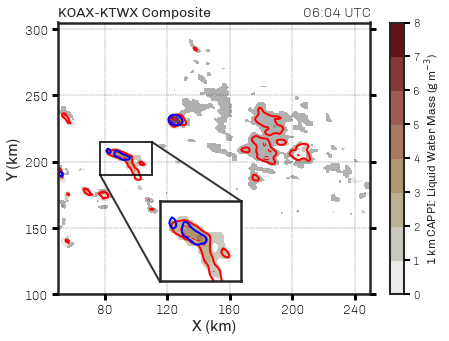

In [62]:
# Liquid Water Mass (Cite: Cifelli et al. 2002)
#------------------------------------------------------------------------------------
from palettable.scientific.sequential import Bilbao_18
fig = plt.figure(figsize=(7,5))
# plot super resolution reflectivity
ax = fig.add_subplot(111)
masked_strat = np.ma.masked_where(eclass['data'] == 2, (base.fields['MW']['data'][2,:,:]))
masked_conv = np.ma.masked_where(eclass['data'] < 2, (base.fields['MW']['data'][2,:,:]))
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0,8,9),
                        cmap=cmap_map(lambda x: x, Bilbao_18.mpl_colormap))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),100),levels=np.linspace(0,8,9),
                 cmap=cmap_map(lambda x: x*0.75, Bilbao_18.mpl_colormap),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[0.5],linewidths=2,colors='r')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1)#,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Liquid Water Mass (g m$^{-3}$)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([50,100,150,200,250,300])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.45, color='k', alpha=0.584, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KOAX-KTWX Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:04 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)

# inset axes....
axins = ax.inset_axes([115,110,52,60.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0,8,9),
                    cmap=cmap_map(lambda x: x, Bilbao_18.mpl_colormap))
#axins.contourf(masked_strat,vmin=0,vmax=3,levels=np.linspace(0,2.5,15),
#             cmap=cmap_map(lambda x: x*0.75, Roma_15_r.mpl_colormap),alpha=1)
cntr1=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[0.5],linewidths=2,colors='r')
cntr2=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr3=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 77,110,190,215
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(50,250)
plt.ylim(100,305)
plt.show()

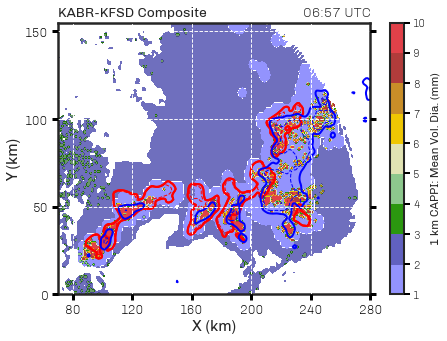

In [21]:
# Mean Volume Diameter (Bringi et al. 2013)
#------------------------------------------------------------------------------------
fig = plt.figure(figsize=(7,5))
from palettable.scientific.diverging import Roma_15_r
# plot super resolution reflectivity
ax = fig.add_subplot(111)
masked_strat = np.ma.masked_where(eclass['data'] == 2, base.fields['PID']['data'][2,:,:])
masked_conv = np.ma.masked_where(eclass['data'] < 2, base.fields['PID']['data'][2,:,:])
shd1 = plt.contourf(np.ma.masked_where(base.fields['reflectivity']['data'][2,:,:]<3,masked_conv),
                    levels=np.linspace(1,10,10),
                    cmap=cmap_map(lambda x: x, pyart.graph.cm.Theodore16))
plt.contourf(np.ma.masked_where(base.fields['reflectivity']['data'][2,:,:]<3,masked_strat),
             levels=np.linspace(1,10,10),
             cmap=cmap_map(lambda x: x*0.75, pyart.graph.cm.Theodore16),alpha=1)
plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.7],linewidths=2,colors='r')
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.7],linewidths=2,colors='r')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.93],linewidths=1,colors='r',linestyles='--')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.75],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
#h1,_ = cntr1.legend_elements()
#h2,_ = cntr2.legend_elements()
#h3,_ = cntr3.legend_elements()
#h4,_ = cntr4.legend_elements()
#LEGD = ax.legend([h1[0],h2[0],h3[0],h4[0]], ['Z$_{DR}$=1.7', 'Z$_{DR}$=2','K$_{DP}$=1','K$_{DP}$=1.7'],
#                 fontsize='x-small',\
#                 prop=dict(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf',size=9.25), \
#                 frameon=True, fancybox=True, shadow=True, loc=2, ncol=2)
CBAR = plt.colorbar(shd1,ticks=[1,2,3,4,5,6,7,8,9,10])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
CBAR.ax.set_yticklabels([1,2,3,4,5,6,7,8,9,10],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Mean Vol. Dia. (mm)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([0,50,100,150,200])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.set_xticks([80,120,160,200,240,280])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.95, color='w', alpha=0.984, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KABR-KFSD Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:57 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)

# inset axes....
#axins = ax.inset_axes([82.5,110,52,57.5], transform=ax.transData)
#shd1 = axins.contourf(masked_conv,levels=np.linspace(0.5,2.5,15),
#                    cmap=cmap_map(lambda x: x, Roma_15_r.mpl_colormap))
#axins.contourf(masked_strat,vmin=0,vmax=3,levels=np.linspace(0.5,2.5,15),
#             cmap=cmap_map(lambda x: x*0.75, Roma_15_r.mpl_colormap),alpha=1)
#axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
#            levels=[1.7],linewidths=2,colors='r')
#cntr1=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
#            levels=[1.7],linewidths=2,colors='r')
#cntr2=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
#            levels=[1.93],linewidths=1,colors='r',linestyles='--')
#cntr3=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
#            levels=[1],linewidths=2,colors='b')
#cntr4=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
#            levels=[1.75],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
#x1, x2, y1, y2 = 130,160,55,95
#axins.set_xlim(x1, x2)
#axins.set_ylim(y1, y2)
#axins.set_xticklabels('')
#axins.set_yticklabels('')
#ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(70,280)
plt.ylim(0,155)
plt.show()

### (iii) 0706

In [9]:
from scipy.ndimage.filters import gaussian_filter
import seaborn as sns
import matplotlib.font_manager as fm
sns.set_style('white',rc={"axes.axisbelow": False})
sns.set_context('poster',font_scale=0.66)
prop = fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf')
x,y = base.x['data'], base.y['data']
dx = np.abs(x[1]-x[0])
dy = np.abs(y[1]-y[0])
eclass = pyart.retrieve.steiner_conv_strat(base, dx=dx, dy=dy, work_level=2000, refl_field='reflectivity')

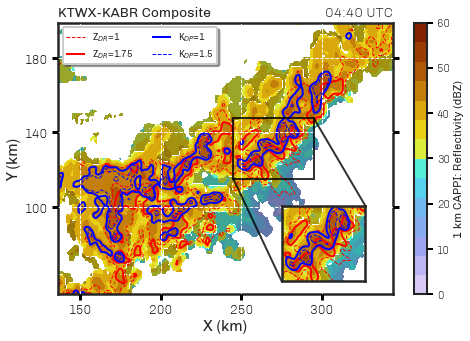

In [10]:
fig = plt.figure(figsize=(7.5,5))
# plot super resolution reflectivity
ax = fig.add_subplot(111)
masked_strat = np.ma.masked_where(eclass['data'] == 2, base.fields['reflectivity']['data'][2,:,:])
masked_conv = np.ma.masked_where(eclass['data'] < 2, base.fields['reflectivity']['data'][2,:,:])
shd1 = plt.contourf(masked_conv,levels=np.linspace(0,60,15),
                    cmap=cmap_map(lambda x: x, pyart.graph.cm.LangRainbow12))
plt.contourf(np.ma.masked_less(masked_strat,0),levels=np.linspace(0,60,15),
             cmap=cmap_map(lambda x: x*0.7, pyart.graph.cm.LangRainbow12),alpha=1)
#cntr0=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
#            levels=[0.5],linewidths=2,colors='#ff0000',linestyles='dotted')
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.8],linewidths=2,colors='r')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.5],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()
h3,_ = cntr3.legend_elements()
h4,_ = cntr4.legend_elements()
LEGD = ax.legend([h1[0],h2[0],h3[0],h4[0]], ['Z$_{DR}$=1', 'Z$_{DR}$=1.75','K$_{DP}$=1','K$_{DP}$=1.5'],
                 fontsize='x-small',\
                 prop=dict(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf',size=9.25), \
                 frameon=True, fancybox=True, shadow=True, loc=2, ncol=2)
CBAR = plt.colorbar(shd1,ticks=[0,10,20,30,40,50,60])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
CBAR.ax.set_yticklabels([0,10,20,30,40,50,60],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Reflectivity (dBZ)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([100,140,180,220])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.95, color='w', alpha=0.984, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KTWX-KABR Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('04:40 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([275,60,52,40.5], transform=ax.transData)
shd1 = axins.contourf(masked_conv,levels=np.linspace(0,60,15),
                    cmap=cmap_map(lambda x: x, pyart.graph.cm.LangRainbow12))
axins.contourf(np.ma.masked_less(masked_strat,3),vmin=0,vmax=60,levels=np.linspace(0,60,20),
             cmap=cmap_map(lambda x: x*0.75, pyart.graph.cm.LangRainbow12),alpha=1)
cntr1=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.8],linewidths=2,colors='r')
cntr3=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.5],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 245,295,115,147.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(136,344)
plt.ylim(53,199)
plt.show()

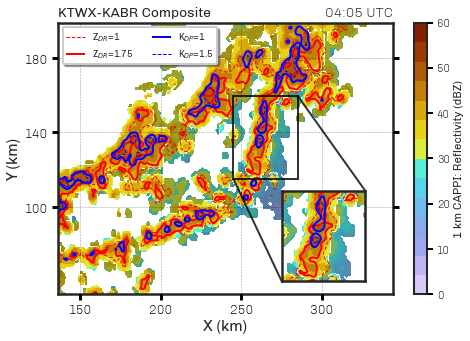

In [13]:
fig = plt.figure(figsize=(7.5,5))
# plot super resolution reflectivity
ax = fig.add_subplot(111)
masked_strat = np.ma.masked_where(eclass['data'] == 2, base.fields['reflectivity']['data'][2,:,:])
masked_conv = np.ma.masked_where(eclass['data'] < 2, base.fields['reflectivity']['data'][2,:,:])
shd1 = plt.contourf(masked_conv,levels=np.linspace(0,60,15),
                    cmap=cmap_map(lambda x: x, pyart.graph.cm.LangRainbow12))
plt.contourf(np.ma.masked_less(masked_strat,0),levels=np.linspace(0,60,15),
             cmap=cmap_map(lambda x: x*0.7, pyart.graph.cm.LangRainbow12),alpha=1)
#cntr0=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
#            levels=[0.5],linewidths=2,colors='#ff0000',linestyles='dotted')
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.8],linewidths=2,colors='r')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.5],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()
h3,_ = cntr3.legend_elements()
h4,_ = cntr4.legend_elements()
LEGD = ax.legend([h1[0],h2[0],h3[0],h4[0]], ['Z$_{DR}$=1', 'Z$_{DR}$=1.75','K$_{DP}$=1','K$_{DP}$=1.5'],
                 fontsize='x-small',\
                 prop=dict(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf',size=9.25), \
                 frameon=True, fancybox=True, shadow=True, loc=2, ncol=2)
CBAR = plt.colorbar(shd1,ticks=[0,10,20,30,40,50,60])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
CBAR.ax.set_yticklabels([0,10,20,30,40,50,60],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Reflectivity (dBZ)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([100,140,180,220])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.55, color='k', alpha=0.384, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KTWX-KABR Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('04:05 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([275,60,52,48.5], transform=ax.transData)
shd1 = axins.contourf(masked_conv,levels=np.linspace(0,60,15),
                    cmap=cmap_map(lambda x: x, pyart.graph.cm.LangRainbow12))
axins.contourf(np.ma.masked_less(masked_strat,3),vmin=0,vmax=60,levels=np.linspace(0,60,20),
             cmap=cmap_map(lambda x: x*0.75, pyart.graph.cm.LangRainbow12),alpha=1)
cntr1=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.8],linewidths=2,colors='r')
cntr3=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.5],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 245,285,115,159.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(136,344)
plt.ylim(53,199)
plt.show()

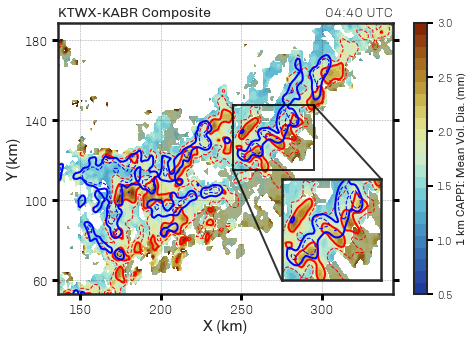

In [18]:
fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.scientific.diverging import Roma_15_r
masked_strat = np.ma.masked_where(eclass['data'] == 2, base.fields['D0']['data'][2,:,:])
masked_conv = np.ma.masked_where(eclass['data'] < 2, base.fields['D0']['data'][2,:,:])
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0.5,3,24),
                    cmap=cmap_map(lambda x: x, Roma_15_r.mpl_colormap))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),100),vmin=0,vmax=3,levels=np.linspace(0.5,3,13),
             cmap=cmap_map(lambda x: x*0.75, Roma_15_r.mpl_colormap),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.8],linewidths=2,colors='r')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.5],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1,ticks=[0.5,1,1.5,2,2.5,3])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Mean Vol. Dia. (mm)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([60,100,140,180,220])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.5, color='k', alpha=0.384, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KTWX-KABR Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('04:40 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([275,60,62,50.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0.5,3,24),
                    cmap=cmap_map(lambda x: x, Roma_15_r.mpl_colormap))
axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),100),vmin=0,vmax=3,levels=np.linspace(0.5,3,24),
             cmap=cmap_map(lambda x: x*0.75, Roma_15_r.mpl_colormap),alpha=1)
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.8],linewidths=2,colors='r')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.5],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 245,295,115,147.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(136,344)
plt.ylim(53,189)
plt.show()

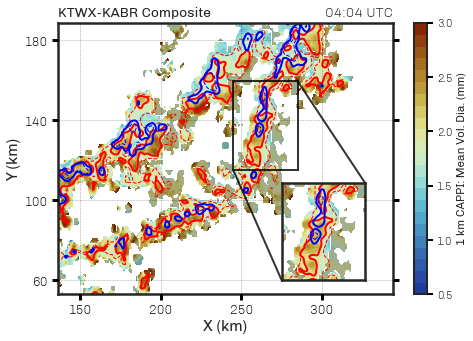

In [15]:
fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.scientific.diverging import Roma_15_r
masked_strat = np.ma.masked_where(eclass['data'] == 2, base.fields['D0']['data'][2,:,:])
masked_conv = np.ma.masked_where(eclass['data'] < 2, base.fields['D0']['data'][2,:,:])
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0.5,3,24),
                    cmap=cmap_map(lambda x: x, Roma_15_r.mpl_colormap))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),100),vmin=0,vmax=3,levels=np.linspace(0.5,3,13),
             cmap=cmap_map(lambda x: x*0.75, Roma_15_r.mpl_colormap),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.8],linewidths=2,colors='r')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.5],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1,ticks=[0.5,1,1.5,2,2.5,3])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Mean Vol. Dia. (mm)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([60,100,140,180,220])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.5, color='k', alpha=0.384, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KTWX-KABR Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('04:04 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([275,60,52,48.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0.5,3,24),
                    cmap=cmap_map(lambda x: x, Roma_15_r.mpl_colormap))
axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),100),vmin=0,vmax=3,levels=np.linspace(0.5,3,24),
             cmap=cmap_map(lambda x: x*0.75, Roma_15_r.mpl_colormap),alpha=1)
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.8],linewidths=2,colors='r')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.5],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 245,285,115,159.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(136,344)
plt.ylim(53,189)
plt.show()

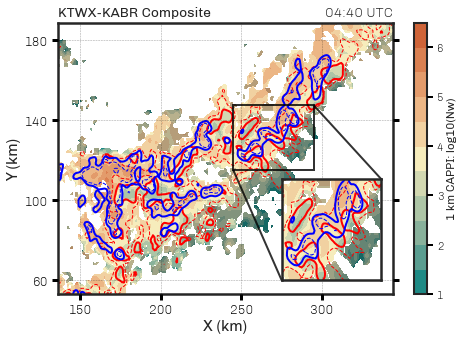

In [12]:
fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.cartocolors.diverging import Geyser_7
masked_strat = np.ma.masked_where(eclass['data'] == 2, (base.fields['Nw']['data'][2,:,:]))
masked_conv = np.ma.masked_where(eclass['data'] < 2, (base.fields['Nw']['data'][2,:,:]))
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                                            masked_conv),100),levels=np.linspace(1,6.5,12),
                        cmap=cmap_map(lambda x: x, Geyser_7.mpl_colormap))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                          masked_strat),8),levels=np.linspace(1,6.5,12),
                 cmap=cmap_map(lambda x: x*0.75, Geyser_7.mpl_colormap),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.8],linewidths=2,colors='r')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.5],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1)#,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: log10(Nw)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([60,100,140,180,220])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.5, color='k', alpha=0.384, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KTWX-KABR Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('04:40 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([275,60,62,50.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                                            masked_conv),100),levels=np.linspace(1,6.5,12),
                        cmap=cmap_map(lambda x: x, Geyser_7.mpl_colormap))
axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                          masked_strat),8),levels=np.linspace(1,6.5,12),
                 cmap=cmap_map(lambda x: x*0.75, Geyser_7.mpl_colormap),alpha=1)
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.8],linewidths=2,colors='r')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.5],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 245,295,115,147.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(136,344)
plt.ylim(53,189)
plt.show()

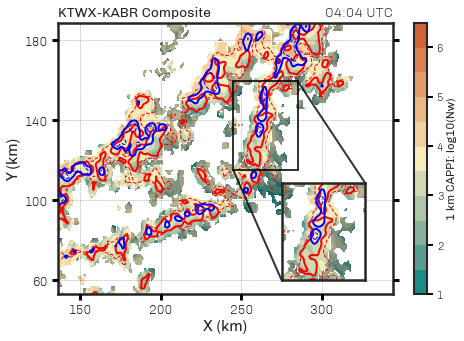

In [18]:
fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.cartocolors.diverging import Geyser_7
masked_strat = np.ma.masked_where(eclass['data'] == 2, (base.fields['Nw']['data'][2,:,:]))
masked_conv = np.ma.masked_where(eclass['data'] < 2, (base.fields['Nw']['data'][2,:,:]))
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                                            masked_conv),100),levels=np.linspace(1,6.5,12),
                        cmap=cmap_map(lambda x: x, Geyser_7.mpl_colormap))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                          masked_strat),8),levels=np.linspace(1,6.5,12),
                 cmap=cmap_map(lambda x: x*0.75, Geyser_7.mpl_colormap),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.8],linewidths=2,colors='r')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.5],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1)#,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: log10(Nw)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([60,100,140,180,220])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.5, color='k', alpha=0.384, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KTWX-KABR Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('04:04 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([275,60,52,48.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                                            masked_conv),100),levels=np.linspace(1,6.5,12),
                        cmap=cmap_map(lambda x: x, Geyser_7.mpl_colormap))
axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                          masked_strat),8),levels=np.linspace(1,6.5,12),
                 cmap=cmap_map(lambda x: x*0.75, Geyser_7.mpl_colormap),alpha=1)
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.8],linewidths=2,colors='r')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.5],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 245,285,115,159.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(136,344)
plt.ylim(53,189)
plt.show()

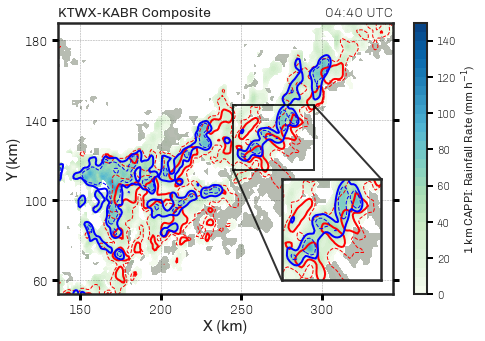

In [13]:
fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.cartocolors.diverging import Geyser_7
masked_strat = np.ma.masked_where(eclass['data'] == 2, (base.fields['rain_blend']['data'][2,:,:]))
masked_conv = np.ma.masked_where(eclass['data'] < 2, (base.fields['rain_blend']['data'][2,:,:]))
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),400),levels=np.linspace(0,150,31),
                        cmap=cmap_map(lambda x: x, matplotlib.cm.GnBu))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),400),levels=np.linspace(0,150,31),
                 cmap=cmap_map(lambda x: x*0.75, matplotlib.cm.GnBu),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.8],linewidths=2,colors='r')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.5],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1)#,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Rainfall Rate (mm h$^{-1}$)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([60,100,140,180,220])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.5, color='k', alpha=0.384, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KTWX-KABR Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('04:40 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([275,60,62,50.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),400),levels=np.linspace(0,150,31),
                        cmap=cmap_map(lambda x: x, matplotlib.cm.GnBu))
axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),400),levels=np.linspace(0,150,31),
                 cmap=cmap_map(lambda x: x*0.75, matplotlib.cm.GnBu),alpha=1)
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.8],linewidths=2,colors='r')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.5],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 245,285,115,159.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(136,344)
plt.ylim(53,189)
plt.show()

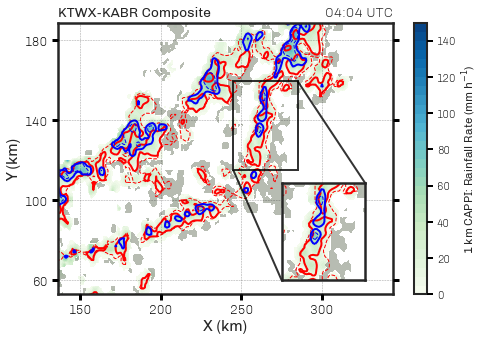

In [19]:
fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.cartocolors.diverging import Geyser_7
masked_strat = np.ma.masked_where(eclass['data'] == 2, (base.fields['rain_blend']['data'][2,:,:]))
masked_conv = np.ma.masked_where(eclass['data'] < 2, (base.fields['rain_blend']['data'][2,:,:]))
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),400),levels=np.linspace(0,150,31),
                        cmap=cmap_map(lambda x: x, matplotlib.cm.GnBu))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),400),levels=np.linspace(0,150,31),
                 cmap=cmap_map(lambda x: x*0.75, matplotlib.cm.GnBu),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.8],linewidths=2,colors='r')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.5],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1)#,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Rainfall Rate (mm h$^{-1}$)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([60,100,140,180,220])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.5, color='k', alpha=0.384, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KTWX-KABR Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('04:04 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([275,60,52,48.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),400),levels=np.linspace(0,150,31),
                        cmap=cmap_map(lambda x: x, matplotlib.cm.GnBu))
axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),400),levels=np.linspace(0,150,31),
                 cmap=cmap_map(lambda x: x*0.75, matplotlib.cm.GnBu),alpha=1)
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.8],linewidths=2,colors='r')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.5],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 245,285,115,159.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(136,344)
plt.ylim(53,189)
plt.show()

/scra6/ft21894/anaconda3/envs/cdat/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


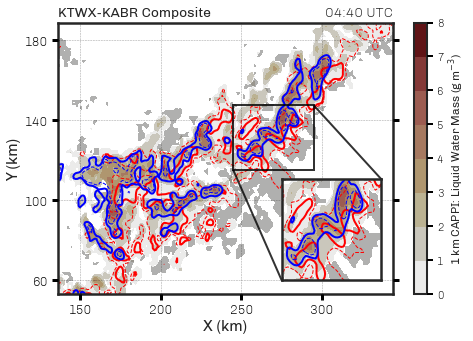

In [16]:
fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.scientific.sequential import Bilbao_18
# plot super resolution reflectivity
ax = fig.add_subplot(111)
masked_strat = np.ma.masked_where(eclass['data'] == 2, (base.fields['MW']['data'][2,:,:]))
masked_conv = np.ma.masked_where(eclass['data'] < 2, (base.fields['MW']['data'][2,:,:]))
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0,8,9),
                        cmap=cmap_map(lambda x: x, Bilbao_18.mpl_colormap))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),100),levels=np.linspace(0,8,9),
                 cmap=cmap_map(lambda x: x*0.75, Bilbao_18.mpl_colormap),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.8],linewidths=2,colors='r')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.5],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1)#,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Liquid Water Mass (g m$^{-3}$)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([60,100,140,180,220])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.5, color='k', alpha=0.384, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KTWX-KABR Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('04:40 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([275,60,62,50.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0,8,9),
                        cmap=cmap_map(lambda x: x, Bilbao_18.mpl_colormap))
axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),100),levels=np.linspace(0,8,9),
                 cmap=cmap_map(lambda x: x*0.75, Bilbao_18.mpl_colormap),alpha=1)
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.8],linewidths=2,colors='r')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.5],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 245,295,115,147.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(136,344)
plt.ylim(53,189)
plt.show()

/scra6/ft21894/anaconda3/envs/cdat/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


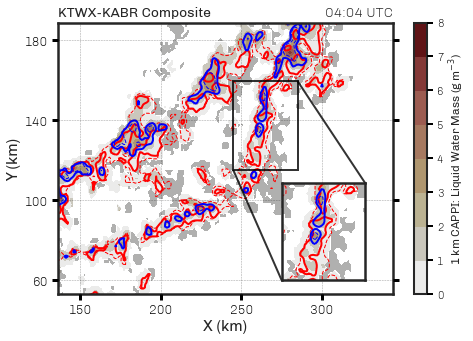

In [20]:
fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.scientific.sequential import Bilbao_18
# plot super resolution reflectivity
ax = fig.add_subplot(111)
masked_strat = np.ma.masked_where(eclass['data'] == 2, (base.fields['MW']['data'][2,:,:]))
masked_conv = np.ma.masked_where(eclass['data'] < 2, (base.fields['MW']['data'][2,:,:]))
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0,8,9),
                        cmap=cmap_map(lambda x: x, Bilbao_18.mpl_colormap))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),100),levels=np.linspace(0,8,9),
                 cmap=cmap_map(lambda x: x*0.75, Bilbao_18.mpl_colormap),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.8],linewidths=2,colors='r')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.5],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1)#,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Liquid Water Mass (g m$^{-3}$)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
ax.set_yticks([60,100,140,180,220])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.5, color='k', alpha=0.384, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KTWX-KABR Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('04:04 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([275,60,52,48.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0,8,9),
                        cmap=cmap_map(lambda x: x, Bilbao_18.mpl_colormap))
axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),100),levels=np.linspace(0,8,9),
                 cmap=cmap_map(lambda x: x*0.75, Bilbao_18.mpl_colormap),alpha=1)
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.8],linewidths=2,colors='r')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=2,colors='b')
axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.5],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 245,285,115,159.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(136,344)
plt.ylim(53,189)
plt.show()

### (iv) 0617

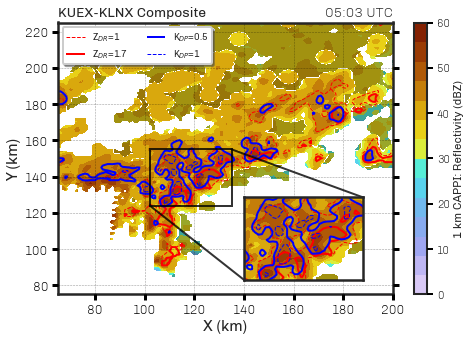

In [19]:
fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
masked_strat = np.ma.masked_where(eclass['data'] == 2, base.fields['reflectivity']['data'][2,:,:])
masked_conv = np.ma.masked_where(eclass['data'] < 2, base.fields['reflectivity']['data'][2,:,:])
shd1 = plt.contourf(masked_conv,levels=np.linspace(0,60,15),
                    cmap=cmap_map(lambda x: x, pyart.graph.cm.LangRainbow12))
plt.contourf(np.ma.masked_less(masked_strat,0),vmin=0,vmax=60,levels=np.linspace(0,60,15),
             cmap=cmap_map(lambda x: x*0.7, pyart.graph.cm.LangRainbow12),alpha=1)
#cntr0=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
#            levels=[0.5],linewidths=2,colors='#ff0000',linestyles='dotted')
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.75],linewidths=2,colors='r')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()
h3,_ = cntr3.legend_elements()
h4,_ = cntr4.legend_elements()
LEGD = ax.legend([h1[0],h2[0],h3[0],h4[0]], ['Z$_{DR}$=1', 'Z$_{DR}$=1.7','K$_{DP}$=0.5','K$_{DP}$=1'],
                 fontsize='x-small',\
                 prop=dict(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf',size=9.25), \
                 frameon=True, fancybox=True, shadow=True, loc=2, ncol=2)
CBAR = plt.colorbar(shd1,ticks=[0,10,20,30,40,50,60])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
CBAR.ax.set_yticklabels([0,10,20,30,40,50,60],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Reflectivity (dBZ)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
#ax.set_yticks([100,140,180,220])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.55, color='k', alpha=0.384, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KUEX-KLNX Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('05:03 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([140,83,48,45.5], transform=ax.transData)
shd1 = axins.contourf(masked_conv,levels=np.linspace(0,60,15),
                    cmap=cmap_map(lambda x: x, pyart.graph.cm.LangRainbow12))
axins.contourf(np.ma.masked_less(masked_strat,0),vmin=0,vmax=60,levels=np.linspace(0,60,15),
             cmap=cmap_map(lambda x: x*0.7, pyart.graph.cm.LangRainbow12),alpha=1)
cntr1=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.75],linewidths=2,colors='r')
cntr3=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 102,135,124,155
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(65,200)
plt.ylim(75,225)
plt.show()

In [23]:
base.fields.keys()

dict_keys(['reflectivity', 'zdr_acorr', 'KDP', 'cross_correlation_ratio', 'MW', 'MI', 'D0', 'Nw', 'mu', 'rain_blend', 'ZDP', 'FI', 'temp_radiosonde', 'z_radiosonde', 'spectrum_width', 'SNR', 'ROI', 'Thurai_class', 'PID'])

In [69]:
conv_zdr = np.ma.masked_where(base.fields['cross_correlation_ratio']['data'][2,:,:]<0.97, base.fields['zdr_acorr']['data'][2,:,:])
conv_kdp = np.ma.masked_where(base.fields['cross_correlation_ratio']['data'][2,:,:]<0.97, base.fields['KDP']['data'][2,:,:])
contours = measure.find_contours(conv_zdr,np.nanpercentile(conv_zdr[conv_zdr>0],95))
contours_kdp = measure.find_contours(conv_kdp,np.nanpercentile(conv_kdp[conv_kdp>0],95))

from shapely.geometry import Polygon
dict_area = []
dict_areakdp = []
for contour in contours:
    if len(contour)<3:
        dict_area.append(0.0)
    else:
        polygon=Polygon(contour)
        dict_area.append(polygon.area)
for contour in contours_kdp:
    if len(contour)<3:
        dict_areakdp.append(0.0)
    else:
        polygon=Polygon(contour)
        dict_areakdp.append(polygon.area)

large_objectindex = np.where(np.asarray(dict_area)>np.percentile(np.asarray(dict_area),95))
large_objectindexkdp = np.where(np.asarray(dict_areakdp)>np.percentile(np.asarray(dict_areakdp),95))

centroid_obj,centroid_objkdp = [],[]
for obj in np.squeeze(large_objectindex):
    polygon_temp = Polygon(contours[obj])
    centroid_obj.append(polygon_temp.centroid.coords)
for obj in np.squeeze(large_objectindexkdp):
    polygon_temp = Polygon(contours_kdp[obj])
    centroid_objkdp.append(polygon_temp.centroid.coords)

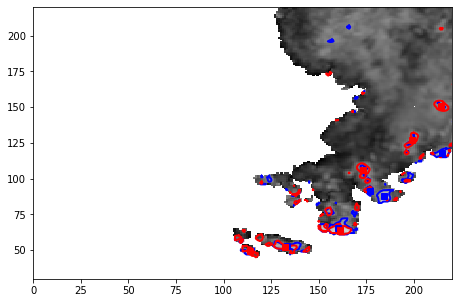

In [70]:
contours = measure.find_contours(conv_zdr,np.nanpercentile(conv_zdr[conv_zdr>0],95))
contours_kdp = measure.find_contours(conv_kdp,np.nanpercentile(conv_kdp[conv_kdp>0],95))

fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
ax.pcolormesh(conv_zdr, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2,color='b')
for contour in contours_kdp:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2,color='r')
colour = ['k','w','r','g','m','chocolate','b','lime']
for i,obj in enumerate(centroid_obj):
    ax.plot(obj.xy[1][0], obj.xy[0][0], linewidth=0,color='b',marker='s')
for obj in centroid_objkdp:
    ax.plot(obj.xy[1][0], obj.xy[0][0], linewidth=0,color='r',marker='s')
plt.xlim(0,220)
plt.ylim(30,220)
plt.show()

In [71]:
min_dist = []
for objz in centroid_obj:
    tmp = [((obj.xy[1][0]-objz.xy[1][0])**2+(obj.xy[0][0]-objz.xy[0][0])**2)**(0.5) for obj in centroid_objkdp]
    if any(element<10 for element in tmp):
        tmpM = np.min(tmp)
        min_dist.append(tmpM)
    else:
        min_dist.append(np.nan)
np.nanmedian(np.asarray(min_dist)[np.asarray(min_dist)<15])

1.4179110884735266

In [72]:
min_dist

[1.2316536182938702, 1.604168558653183, nan, nan, nan, nan]

In [ ]:
np.asarray(tmp)

In [45]:
#7(4:39):3.69; 16(542):6.56; (635):9.51, (732):4.91, (741):4.64; (750):2.36

In [53]:
print(np.asarray(min_dist)[np.asarray(min_dist)<15],
len(np.asarray(min_dist)[np.asarray(min_dist)<4])/len(np.asarray(min_dist)[np.asarray(min_dist)<15])*100)

[ 2.18025994 14.9322362 ] 50.0


In [66]:
print(np.min(dist1),np.min(dist2),np.min(dist3),np.min(dist4),np.min(dist5),np.min(dist6))

18.581046595764843 17.943810473834183 12.892326281471295 4.436293637266343 7.923960775373613 5.285618126989493


In [60]:
dict_area = []
for contour in contours:
    if len(measure.approximate_polygon(contour, tolerance=2.5))<3:
        dict_area.append(0.0)
    else:
        polygon = Polygon(measure.approximate_polygon(contour, tolerance=2.5))
        dict_area.append(polygon.area)

In [64]:
np.where(np.asarray(dict_area)>0)

(array([30, 50, 62, 68]),)

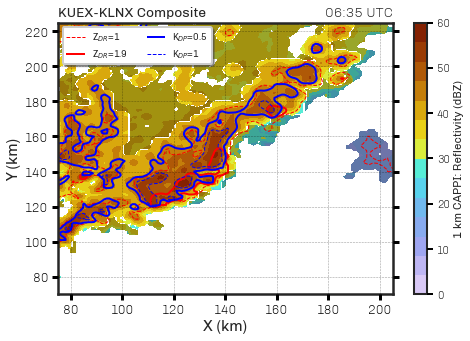

In [10]:
fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
masked_strat = np.ma.masked_where(eclass['data'] == 2, base.fields['reflectivity']['data'][2,:,:])
masked_conv = np.ma.masked_where(eclass['data'] < 2, base.fields['reflectivity']['data'][2,:,:])
shd1 = plt.contourf(masked_conv,levels=np.linspace(0,60,15),
                    cmap=cmap_map(lambda x: x, pyart.graph.cm.LangRainbow12))
plt.contourf(np.ma.masked_less(masked_strat,0),vmin=0,vmax=60,levels=np.linspace(0,60,15),
             cmap=cmap_map(lambda x: x*0.7, pyart.graph.cm.LangRainbow12),alpha=1)
#cntr0=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
#            levels=[0.5],linewidths=2,colors='#ff0000',linestyles='dotted')
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[2.28],linewidths=2,colors='r')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1.26],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()
h3,_ = cntr3.legend_elements()
h4,_ = cntr4.legend_elements()
LEGD = ax.legend([h1[0],h2[0],h3[0],h4[0]], ['Z$_{DR}$=1', 'Z$_{DR}$=1.9','K$_{DP}$=0.5','K$_{DP}$=1'],
                 fontsize='x-small',\
                 prop=dict(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf',size=9.25), \
                 frameon=True, fancybox=True, shadow=True, loc=2, ncol=2)
CBAR = plt.colorbar(shd1,ticks=[0,10,20,30,40,50,60])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
CBAR.ax.set_yticklabels([0,10,20,30,40,50,60],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Reflectivity (dBZ)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
#ax.set_yticks([100,140,180,220])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.55, color='k', alpha=0.384, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KUEX-KLNX Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:35 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
plt.xlim(65+10,200+5)
plt.ylim(75-5,225)
plt.show()

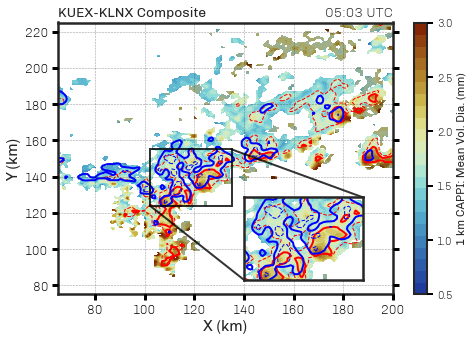

In [20]:
fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.scientific.diverging import Roma_15_r
masked_strat = np.ma.masked_where(eclass['data'] == 2, base.fields['D0']['data'][2,:,:])
masked_conv = np.ma.masked_where(eclass['data'] < 2, base.fields['D0']['data'][2,:,:])
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0.5,3,24),
                    cmap=cmap_map(lambda x: x, Roma_15_r.mpl_colormap))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),100),vmin=0,vmax=3,levels=np.linspace(0.5,3,13),
             cmap=cmap_map(lambda x: x*0.75, Roma_15_r.mpl_colormap),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.75],linewidths=2,colors='r')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1,ticks=[0.5,1,1.5,2,2.5,3])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Mean Vol. Dia. (mm)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
#ax.set_yticks([100,140,180,220])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.55, color='k', alpha=0.384, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KUEX-KLNX Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('05:03 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([140,83,48,45.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0.5,3,24),
                    cmap=cmap_map(lambda x: x, Roma_15_r.mpl_colormap))
axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),100),vmin=0,vmax=3,levels=np.linspace(0.5,3,13),
             cmap=cmap_map(lambda x: x*0.75, Roma_15_r.mpl_colormap),alpha=1)
cntr1=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.75],linewidths=2,colors='r')
cntr3=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 102,135,124,155
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(65,200)
plt.ylim(75,225)
plt.show()

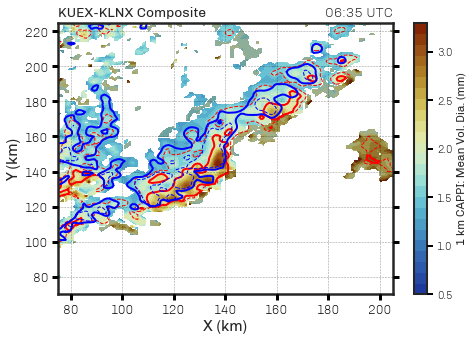

In [10]:
fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.scientific.diverging import Roma_15_r
masked_strat = np.ma.masked_where(eclass['data'] == 2, base.fields['D0']['data'][2,:,:])
masked_conv = np.ma.masked_where(eclass['data'] < 2, base.fields['D0']['data'][2,:,:])
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0.5,3.3,26),
                    cmap=cmap_map(lambda x: x, Roma_15_r.mpl_colormap))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),100),vmin=0,vmax=3,levels=np.linspace(0.5,3,13),
             cmap=cmap_map(lambda x: x*0.75, Roma_15_r.mpl_colormap),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.9],linewidths=2,colors='r')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1,ticks=[0.5,1,1.5,2,2.5,3])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Mean Vol. Dia. (mm)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
#ax.set_yticks([100,140,180,220])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.55, color='k', alpha=0.384, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KUEX-KLNX Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:35 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
plt.xlim(65+10,200+5)
plt.ylim(75-5,225)
plt.show()

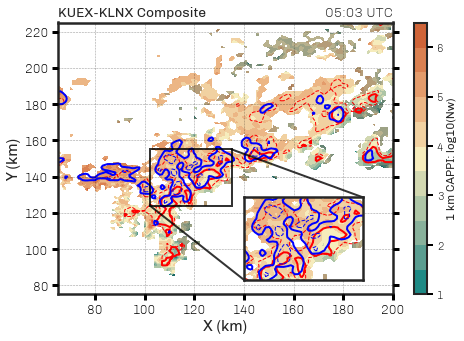

In [21]:
fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.cartocolors.diverging import Geyser_7
masked_strat = np.ma.masked_where(eclass['data'] == 2, (base.fields['Nw']['data'][2,:,:]))
masked_conv = np.ma.masked_where(eclass['data'] < 2, (base.fields['Nw']['data'][2,:,:]))
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                                            masked_conv),100),levels=np.linspace(1,6.5,12),
                        cmap=cmap_map(lambda x: x, Geyser_7.mpl_colormap))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                          masked_strat),8),levels=np.linspace(1,6.5,12),
                 cmap=cmap_map(lambda x: x*0.75, Geyser_7.mpl_colormap),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.75],linewidths=2,colors='r')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1)#,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: log10(Nw)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
#ax.set_yticks([100,140,180,220])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.55, color='k', alpha=0.384, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KUEX-KLNX Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('05:03 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([140,83,48,45.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                                            masked_conv),100),levels=np.linspace(1,6.5,12),
                        cmap=cmap_map(lambda x: x, Geyser_7.mpl_colormap))
axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                          masked_strat),8),levels=np.linspace(1,6.5,12),
                 cmap=cmap_map(lambda x: x*0.75, Geyser_7.mpl_colormap),alpha=1)
cntr1=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.75],linewidths=2,colors='r')
cntr3=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 102,135,124,155
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(65,200)
plt.ylim(75,225)
plt.show()

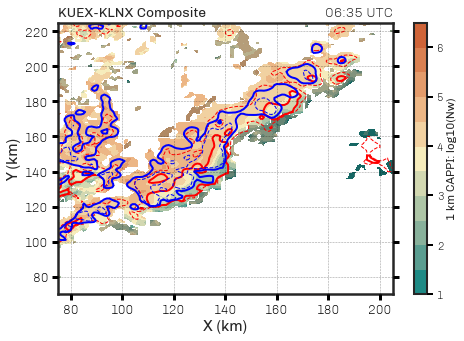

In [11]:
fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.cartocolors.diverging import Geyser_7
masked_strat = np.ma.masked_where(eclass['data'] == 2, (base.fields['Nw']['data'][2,:,:]))
masked_conv = np.ma.masked_where(eclass['data'] < 2, (base.fields['Nw']['data'][2,:,:]))
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                                            masked_conv),100),levels=np.linspace(1,6.5,12),
                        cmap=cmap_map(lambda x: x, Geyser_7.mpl_colormap))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                          masked_strat),8),levels=np.linspace(1,6.5,12),
                 cmap=cmap_map(lambda x: x*0.75, Geyser_7.mpl_colormap),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.9],linewidths=2,colors='r')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1)#,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: log10(Nw)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
#ax.set_yticks([100,140,180,220])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.55, color='k', alpha=0.384, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KUEX-KLNX Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:35 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
plt.xlim(65+10,200+5)
plt.ylim(75-5,225)
plt.show()

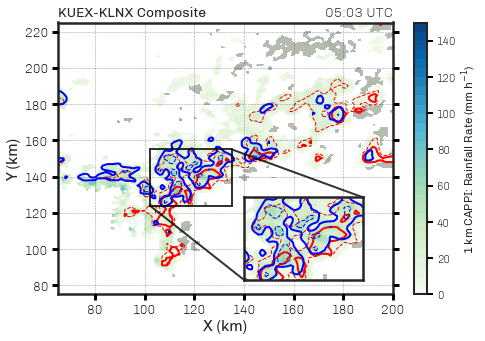

In [22]:
fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.cartocolors.diverging import Geyser_7
masked_strat = np.ma.masked_where(eclass['data'] == 2, (base.fields['rain_blend']['data'][2,:,:]))
masked_conv = np.ma.masked_where(eclass['data'] < 2, (base.fields['rain_blend']['data'][2,:,:]))
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),400),levels=np.linspace(0,150,31),
                        cmap=cmap_map(lambda x: x, matplotlib.cm.GnBu))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),400),levels=np.linspace(0,150,31),
                 cmap=cmap_map(lambda x: x*0.75, matplotlib.cm.GnBu),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.75],linewidths=2,colors='r')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1)#,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Rainfall Rate (mm h$^{-1}$)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
#ax.set_yticks([100,140,180,220])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.55, color='k', alpha=0.384, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KUEX-KLNX Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('05:03 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([140,83,48,45.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),400),levels=np.linspace(0,150,31),
                        cmap=cmap_map(lambda x: x, matplotlib.cm.GnBu))
axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),400),levels=np.linspace(0,150,31),
                 cmap=cmap_map(lambda x: x*0.75, matplotlib.cm.GnBu),alpha=1)
cntr1=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.75],linewidths=2,colors='r')
cntr3=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 102,135,124,155
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(65,200)
plt.ylim(75,225)
plt.show()

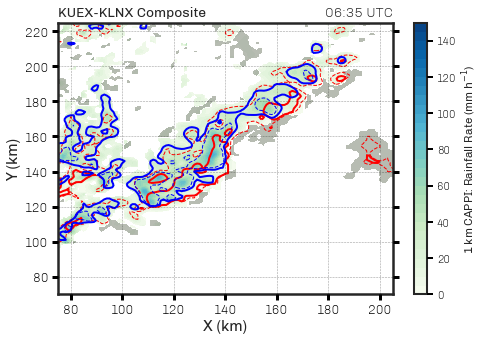

In [12]:
fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.cartocolors.diverging import Geyser_7
masked_strat = np.ma.masked_where(eclass['data'] == 2, (base.fields['rain_blend']['data'][2,:,:]))
masked_conv = np.ma.masked_where(eclass['data'] < 2, (base.fields['rain_blend']['data'][2,:,:]))
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),400),levels=np.linspace(0,150,31),
                        cmap=cmap_map(lambda x: x, matplotlib.cm.GnBu))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),400),levels=np.linspace(0,150,31),
                 cmap=cmap_map(lambda x: x*0.75, matplotlib.cm.GnBu),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.9],linewidths=2,colors='r')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1)#,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Rainfall Rate (mm h$^{-1}$)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
#ax.set_yticks([100,140,180,220])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.55, color='k', alpha=0.384, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KUEX-KLNX Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:35 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
plt.xlim(65+10,200+5)
plt.ylim(75-5,225)
plt.show()

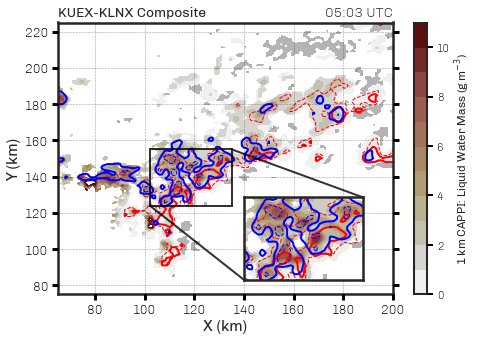

In [26]:
fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.cartocolors.diverging import Geyser_7
from palettable.scientific.sequential import Bilbao_18
masked_strat = np.ma.masked_where(eclass['data'] == 2, (base.fields['MW']['data'][2,:,:]))
masked_conv = np.ma.masked_where(eclass['data'] < 2, (base.fields['MW']['data'][2,:,:]))
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0,11,12),
                        cmap=cmap_map(lambda x: x, Bilbao_18.mpl_colormap))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),100),levels=np.linspace(0,11,12),
                 cmap=cmap_map(lambda x: x*0.75, Bilbao_18.mpl_colormap),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.75],linewidths=2,colors='r')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1)#,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Liquid Water Mass (g m$^{-3}$)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
#ax.set_yticks([100,140,180,220])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.55, color='k', alpha=0.384, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KUEX-KLNX Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('05:03 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
# inset axes....
axins = ax.inset_axes([140,83,48,45.5], transform=ax.transData)
shd1 = axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0,9,10),
                        cmap=cmap_map(lambda x: x, Bilbao_18.mpl_colormap))
axins.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),100),levels=np.linspace(0,9,10),
                 cmap=cmap_map(lambda x: x*0.75, Bilbao_18.mpl_colormap),alpha=1)
cntr1=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=axins.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.75],linewidths=2,colors='r')
cntr3=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=axins.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')
# sub region of the original image
x1, x2, y1, y2 = 102,135,124,155
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins,edgecolor='k',alpha=0.8)
plt.xlim(65,200)
plt.ylim(75,225)
plt.show()

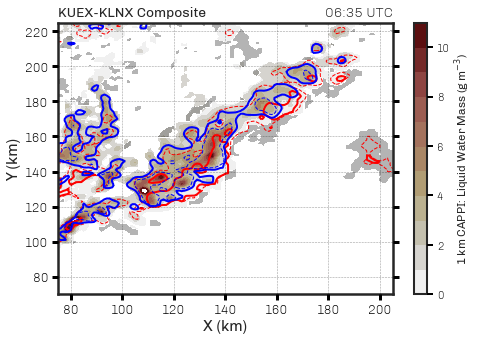

In [13]:
fig = plt.figure(figsize=(7.5,5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
from palettable.cartocolors.diverging import Geyser_7
from palettable.scientific.sequential import Bilbao_18
masked_strat = np.ma.masked_where(eclass['data'] == 2, (base.fields['MW']['data'][2,:,:]))
masked_conv = np.ma.masked_where(eclass['data'] < 2, (base.fields['MW']['data'][2,:,:]))
shd1 = plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_conv),100),levels=np.linspace(0,11,12),
                        cmap=cmap_map(lambda x: x, Bilbao_18.mpl_colormap))
plt.contourf(np.ma.masked_greater(np.ma.masked_where(base.fields['zdr_acorr']['data'][2,:,:]<0,
                                      masked_strat),100),levels=np.linspace(0,11,12),
                 cmap=cmap_map(lambda x: x*0.75, Bilbao_18.mpl_colormap),alpha=1)
cntr1=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1],linewidths=1,colors='r',linestyles='--')
cntr2=plt.contour(gaussian_filter(base.fields['zdr_acorr']['data'][2,:,:],0.87),
            levels=[1.9],linewidths=2,colors='r')
cntr3=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[0.5],linewidths=2,colors='b')
cntr4=plt.contour(gaussian_filter(base.fields['KDP']['data'][2,:,:],0.97),
            levels=[1],linewidths=1,colors='b',linestyles='--')

# Legend and colorbar
#----------------------------------------------------------------------------------
CBAR = plt.colorbar(shd1)#,ticks=[0.5,1,1.5,2,2.5])
CBAR.ax.tick_params(direction='out',length=6,width=2,colors='k')
#CBAR.ax.set_yticklabels([0.5,1,1.5,2,2.5],fontproperties=prop,fontsize=10.5)
for txt in CBAR.ax.get_yticklabels():
    txt.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=10.5))
CBAR.outline.set_linewidth(2.05)
CBAR.set_label('1 km CAPPI: Liquid Water Mass (g m$^{-3}$)',fontproperties=prop,fontsize=11.5)

# Tickmark settings
#----------------------------------------------------------------------------------
#ax.set_yticks([100,140,180,220])
for label in ax.get_yticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
#ax.set_xticks([80,120,160,200,240])
for label in ax.get_xticklabels():
    label.set_fontproperties(fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf',size=12.5))
ax.grid(linewidth=0.55, color='k', alpha=0.384, linestyle='--')
ax.tick_params(axis='both',which='major',direction='out',length=6,width=3,colors='k',right=True,left=True,bottom=True)
ax.spines['top'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.set_ylabel('Y (km)',fontproperties=prop,fontsize=15.5)
ax.set_xlabel('X (km)',fontproperties=prop,fontsize=15.5)
#plt.title('06/20-07/01',fontproperties=prop,loc='left',fontsize=15.03)
plt.title('KUEX-KLNX Composite',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Regular.ttf'),loc='left',
         fontsize=14.03)
plt.title('06:35 UTC',
          fontproperties=fm.FontProperties(fname='/scra6/ft21894/anaconda3/font/Chivo/ttf/Chivo-Thin.ttf'),loc='right',
         fontsize=14.03)
plt.xlim(65+10,200+5)
plt.ylim(75-5,225)
plt.show()